### Guardians of the Crypto
#### A Streamlit Application for Enhanced Price Prediction and Informed Decision-Making
###### by Mirna Philip, Justin Farnan, and Arya Shahbazi

The cryptocurrency market is highly unpredictable, with prices fluctuating significantly in short periods, making it challenging for investors and traders to make informed decisions. Our project, Guardians of the Crypto, aims to address this issue by leveraging historical price data to predict cryptocurrency price changes. By focusing on this approach, we aim to create a reliable tool that aids traders and investors in understanding the market better and making confident decisions. Our primary goals include collecting historical price data for major cryptocurrencies using the Coinbase API, cleaning and preparing this data, and training various machine learning models, from simple models like Linear Regression to advanced ones like Long Short-Term Memory (LSTM) networks, to accurately predict cryptocurrency price changes. We will evaluate these models, enhance the best one, and develop a Streamlit application that integrates historical price data and other trading metrics to support cryptocurrency traders and investors in making better decisions in a volatile market.

## Data Processing and Modeling

### Data Processing

The data processing phase ensures the quality and reliability of the dataset used for modeling. This involves scaling and normalization, which are crucial for preparing the data. Features were standardized to maintain comparability across different scales, essential for models sensitive to feature magnitudes. The data preparation process applied the RobustScaler to account for outliers. Numerical columns, excluding the target variable, were scaled in both the training and test sets. 

Key steps in data processing:
1. **Data Splitting**: The dataset was split into training and test sets, maintaining temporal order. This split is crucial for evaluating the model on unseen data while preserving the integrity of time series analysis.
2. **Scaling and Normalization**: Applied the RobustScaler to handle outliers and standardized the features. Ensured that the scaling process avoided introducing near-zero values that could distort model performance.

### Modeling

The modeling phase involved several steps to ensure precise and insightful results. The initial approach used linear regression, followed by more advanced models like XGBoost to improve prediction accuracy. 

Key steps in the modeling phase:
1. **Model Selection**: Started with linear regression and progressed to more sophisticated models like XGBoost.
2. **Hyperparameter Tuning**: Used GridSearchCV to refine models and identify the best parameters.
3. **Model Evaluation**: Assessed models using metrics such as MSE, RMSE, MAE, and R-Squared to evaluate their performance.

These phases illustrate the project's structured approach to achieving accurate and reliable cryptocurrency price predictions. The ultimate goal is to develop a Streamlit application that integrates these models, providing a valuable tool for cryptocurrency traders and investors to make informed decisions.

In [1]:
# Standard libraries
import os
import warnings
import itertools

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Environment variables
from dotenv import load_dotenv

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

# Machine learning libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    median_absolute_error, mean_squared_log_error,
    mean_absolute_percentage_error
)

# Time series analysis
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from prophet import Prophet

# Additional libraries
import ta  # Technical Analysis library
from ipywidgets import interact, widgets
from IPython.display import display, clear_output

# Time series learning
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# Deep learning libraries
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Gradient boosting libraries
import xgboost as xgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Load environment variables
_ = load_dotenv()

# Configuration to suppress warnings
warnings.filterwarnings('ignore')

# Additional configurations for better control over visualizations (optional)
plt.style.use('ggplot')  # For ggplot-like style in plots
pd.options.display.max_columns = None  # Ensure all columns are visible when displaying DataFrames


## Loading the database

In [2]:
# Define the path to the dataset
file_path = 'Cleaned_Data/cleaned_crypto_updated_722.csv'

# Load the dataset
df = pd.read_csv(file_path)
df.head()

,time,product_id,low,high,open,close,volume,price_change,average_price,volatility,pct_change,day_of_week,day_name,close_lag_1,volume_lag_1,close_lag_3,volume_lag_3,close_lag_7,volume_lag_7,close_MA10,close_ema_7,close_ema_14,close_ema_30,RSI,MACD,Signal_Line,volatility_7d,volatility_14d,volatility_30d,momentum_1d,momentum_7d,momentum_30d
0,2021-07-16,ADA-USD,1.16610,1.2452,1.22490,1.17140,3.676491e+07,-0.05350,1.205650,6.783295,NaN,4,Friday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.17140,1.17140,1.17140,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-07-16,COMP-USD,367.10000,410.5000,398.45000,367.89000,2.381554e+04,-30.56000,388.800000,11.822392,NaN,4,Friday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,367.89000,367.89000,367.89000,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-07-16,ETH-USD,1850.15000,1965.3500,1918.99000,1877.22000,1.842217e+05,-41.77000,1907.750000,6.226522,NaN,4,Friday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1877.22000,1877.22000,1877.22000,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-07-16,LINK-USD,15.13583,16.3345,15.77288,15.23963,2.246281e+06,-0.53325,15.735165,7.919420,NaN,4,Friday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.23963,15.23963,15.23963,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-07-16,LTC-USD,120.44000,127.8200,125.92000,120.68000,1.305546e+05,-5.24000,124.130000,6.127532,NaN,4,Friday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.68000,120.68000,120.68000,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df_shape = df.shape
print(f"The dataset contains {df_shape[1]} columns and {df_shape[0]} rows.")


The dataset contains 32 columns and 10764 rows.


In [4]:
# Verify Data Types
print("Data Types:")
print(df.dtypes)

# Check for Null Values
print("\nNull Values:")
print(df.isnull().sum())

# Check Value Ranges for Numerical Columns
print("\nValue Ranges for Numerical Columns:")
print(df.describe())

# Check Unique Values for Categorical Columns
print("\nUnique Values for Categorical Columns:")
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}")


Data Types:
time               object
product_id         object
low               float64
high              float64
open              float64
close             float64
volume            float64
price_change      float64
average_price     float64
volatility        float64
pct_change        float64
day_of_week         int64
day_name           object
close_lag_1       float64
volume_lag_1      float64
close_lag_3       float64
volume_lag_3      float64
close_lag_7       float64
volume_lag_7      float64
close_MA10        float64
close_ema_7       float64
close_ema_14      float64
close_ema_30      float64
RSI               float64
MACD              float64
Signal_Line       float64
volatility_7d     float64
volatility_14d    float64
volatility_30d    float64
momentum_1d       float64
momentum_7d       float64
momentum_30d      float64
dtype: object

Null Values:
time                0
product_id          0
low                 0
high                0
open                0
close             

In [5]:
# Check for unique values in 'day_of_week' before mapping
print("\nUnique Values in 'day_of_week':")
print(df['day_of_week'].unique())


Unique Values in 'day_of_week':
[4 5 6 0 1 2 3]


In [6]:
# Convert 'time' to datetime
df['time'] = pd.to_datetime(df['time'])

# Map 'day_of_week' integers to day names
day_of_week_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df['day_of_week'] = df['day_of_week'].map(day_of_week_mapping)

# Verify mapping
print("\nUnique Values for 'day_of_week' after mapping:")
print(df['day_of_week'].unique())


Unique Values for 'day_of_week' after mapping:
['Friday' 'Saturday' 'Sunday' 'Monday' 'Tuesday' 'Wednesday' 'Thursday']


### Column Type Definitions and Data Type Conversion

In [7]:
# Define dictionaries for column types
numerical_cols = {
    'low': 'float64',
    'high': 'float64',
    'open': 'float64',
    'close': 'float64',
    'volume': 'float64',
    'price_change': 'float64',
    'average_price': 'float64',
    'volatility': 'float64',
    'pct_change': 'float64',
    'close_lag_1': 'float64',
    'volume_lag_1': 'float64',
    'close_lag_3': 'float64',
    'volume_lag_3': 'float64',
    'close_lag_7': 'float64',
    'volume_lag_7': 'float64',
    'close_MA10': 'float64',
    'close_ema_7': 'float64',
    'close_ema_14': 'float64',
    'close_ema_30': 'float64',
    'RSI': 'float64',
    'MACD': 'float64',
    'Signal_Line': 'float64',
    'volatility_7d': 'float64',
    'volatility_14d': 'float64',
    'volatility_30d': 'float64',
    'momentum_1d': 'float64',
    'momentum_7d': 'float64',
    'momentum_30d': 'float64'
}

categorical_cols = {
    'day_of_week': 'object',  # Keep as object since it now contains day names
    'product_id': 'category'
}

# Convert numerical columns to correct data types
for col, dtype in numerical_cols.items():
    if col in df.columns:
        df[col] = df[col].astype(dtype)

# Convert categorical columns to correct data types
for col, dtype in categorical_cols.items():
    if col in df.columns:
        df[col] = df[col].astype(dtype)

# Verify Data Types After Correction
print("\nCorrected Data Types:")
print(df.dtypes)


Corrected Data Types:
time              datetime64[ns]
product_id              category
low                      float64
high                     float64
open                     float64
close                    float64
volume                   float64
price_change             float64
average_price            float64
volatility               float64
pct_change               float64
day_of_week               object
day_name                  object
close_lag_1              float64
volume_lag_1             float64
close_lag_3              float64
volume_lag_3             float64
close_lag_7              float64
volume_lag_7             float64
close_MA10               float64
close_ema_7              float64
close_ema_14             float64
close_ema_30             float64
RSI                      float64
MACD                     float64
Signal_Line              float64
volatility_7d            float64
volatility_14d           float64
volatility_30d           float64
momentum_1d         

### Handling Missing and Zero Values in the Dataset

This code defines and applies functions to clean a dataset by handling missing and zero values, ensuring data quality and reliability for further analysis and modeling. The `handle_missing_values(df)` function iterates through each unique `product_id`, applying forward and backward filling to handle missing values in categorical and numerical columns and dropping rows with missing `product_id`. After verifying the absence of null values, the `handle_zero_values(df, small_value=1e-5)` function replaces zero values in numerical columns (excluding `day_of_week`) with a small value to prevent distortions in model performance. The `day_name` column is then dropped as `day_of_week` is sufficient, with the final DataFrame verified to be free of missing and zero values.

In [8]:
# Function to handle missing values for each product ID
def handle_missing_values(df):
    cleaned_dataframes = []

    for product_id in df['product_id'].unique():
        group = df[df['product_id'] == product_id].copy()

        # Forward and backward fill for categorical columns
        group['day_of_week'] = group['day_of_week'].ffill().bfill()
        
        # Drop rows with missing 'product_id'
        group.dropna(subset=['product_id'], inplace=True)

        # Forward and backward fill for remaining categorical columns if any
        categorical_cols = ['day_of_week']
        for col in categorical_cols:
            if group[col].isnull().sum() > 0:
                group[col] = group[col].ffill().bfill()

        # Forward and backward fill for numerical columns
        numerical_cols = group.select_dtypes(include=[np.number]).columns.tolist()
        for col in numerical_cols:
            if group[col].isnull().sum() > 0:
                group[col] = group[col].ffill().bfill()

        cleaned_dataframes.append(group)

    df_cleaned = pd.concat(cleaned_dataframes, ignore_index=True)
    return df_cleaned

# Apply the missing values handling function
df_cleaned = handle_missing_values(df)

# Verify missing values
print("Remaining null values per column after handling:")
print(df_cleaned.isnull().sum())

# Function to handle zero values for each product ID
def handle_zero_values(df, small_value=1e-5):
    cleaned_dataframes = []

    for product_id in df['product_id'].unique():
        group = df[df['product_id'] == product_id].copy()

        numerical_cols = group.select_dtypes(include=[np.number]).columns.tolist()
        for col in numerical_cols:
            if col != 'day_of_week':  # Exclude 'day_of_week' as 0 represents 'Monday'
                group[col] = group[col].replace(0, small_value)

        cleaned_dataframes.append(group)

    df_cleaned = pd.concat(cleaned_dataframes, ignore_index=True)
    return df_cleaned

# Apply the zero values handling function
df_cleaned = handle_zero_values(df_cleaned)

# Verify zero values
zero_values = df_cleaned.eq(0).sum()
print("Zero values per column after handling:")
print(zero_values)

# Dropping 'day_name' since 'day_of_week' is sufficient
df_cleaned.drop(columns=['day_name'], inplace=True)

# Verify the DataFrame after dropping the column
print("Columns after dropping 'day_name':")
print(df_cleaned.columns)


Remaining null values per column after handling:
time              0
product_id        0
low               0
high              0
open              0
close             0
volume            0
price_change      0
average_price     0
volatility        0
pct_change        0
day_of_week       0
day_name          0
close_lag_1       0
volume_lag_1      0
close_lag_3       0
volume_lag_3      0
close_lag_7       0
volume_lag_7      0
close_MA10        0
close_ema_7       0
close_ema_14      0
close_ema_30      0
RSI               0
MACD              0
Signal_Line       0
volatility_7d     0
volatility_14d    0
volatility_30d    0
momentum_1d       0
momentum_7d       0
momentum_30d      0
dtype: int64
Zero values per column after handling:
time              0
product_id        0
low               0
high              0
open              0
close             0
volume            0
price_change      0
average_price     0
volatility        0
pct_change        0
day_of_week       0
day_name          0

### Feature Engineering for Enhanced Data Analysis

This code defines and applies feature engineering functions to enrich a dataset with additional features, ensuring more robust and insightful analysis for further modeling. The functions create lagged features, rolling statistics, exponential moving averages, Bollinger Bands, stochastic oscillators, Williams %R, volume oscillators, and percentage lag features. For each unique `product_id`, the dataset is processed by adding these features, handling missing values through forward and backward filling, and addressing zero values. After applying these transformations, the processed groups are combined back into a single DataFrame. The code then verifies the absence of null values and displays a sample of the updated DataFrame, confirming the successful implementation of feature engineering and data imputation.

In [9]:
# Feature Engineering Functions
def add_lag_features(group, cols, lags):
    for col in cols:
        for lag in lags:
            group[f'{col}_lag_{lag}'] = group[col].shift(lag)
    return group

def add_rolling_stats(group, cols, windows):
    for col in cols:
        for window in windows:
            group[f'{col}_rolling_mean_{window}'] = group[col].rolling(window=window).mean()
            group[f'{col}_rolling_std_{window}'] = group[col].rolling(window=window).std()
    return group

def add_ema(group, cols, spans):
    for col in cols:
        for span in spans:
            group[f'{col}_ema_{span}'] = group[col].ewm(span=span, adjust=False).mean()
    return group

def add_bollinger_bands(group, col, window):
    rolling_mean = group[col].rolling(window).mean()
    rolling_std = group[col].rolling(window).std()
    group[f'{col}_bollinger_upper_band'] = rolling_mean + (rolling_std * 2)
    group[f'{col}_bollinger_lower_band'] = rolling_mean - (rolling_std * 2)
    return group

def add_stochastic_oscillator(group, window=14):
    group['stochastic_oscillator'] = ((group['close'] - group['low'].rolling(window).min()) / 
                                      (group['high'].rolling(window).max() - group['low'].rolling(window).min())) * 100
    return group

def add_williams_r(group, window=14):
    group['williams_r'] = ((group['high'].rolling(window).max() - group['close']) / 
                           (group['high'].rolling(window).max() - group['low'].rolling(window).min())) * -100
    return group

def add_volume_oscillator(group, short_window=14, long_window=28):
    short_ema = group['volume'].ewm(span=short_window, adjust=False).mean()
    long_ema = group['volume'].ewm(span=long_window, adjust=False).mean()
    group['volume_oscillator'] = short_ema - long_ema
    return group

def add_pct_lag_features(group, col, lags):
    for lag in lags:
        group[f'{col}_pct_lag_{lag}'] = group[col].pct_change(lag)
    return group

def add_all_features(group):
    rolling_windows = [7, 14, 30]
    ema_spans = [7, 14, 30]
    bollinger_window = 20
    
    group = add_lag_features(group, ['close', 'volume'], rolling_windows)
    group = add_rolling_stats(group, ['close', 'volume'], rolling_windows)
    group = add_ema(group, ['close'], ema_spans)
    group = add_bollinger_bands(group, 'close', bollinger_window)
    group = add_stochastic_oscillator(group)
    group = add_williams_r(group)
    group = add_volume_oscillator(group)
    group['month'] = group['time'].dt.month
    group['quarter'] = group['time'].dt.quarter
    group['high_low_ratio'] = group['high'] / group['low']
    group['close_open_ratio'] = group['close'] / group['open']
    group['log_return_lag_1'] = np.log(group['close'] / group['close'].shift(1))
    group['log_return_lag_7'] = np.log(group['close'] / group['close'].shift(7))
    group = add_pct_lag_features(group, 'close', rolling_windows)
    return group

# Process each product_id group separately
df_cleaned_list = []
numerical_cols_list = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()  # Convert numerical_cols to a list
for product_id, group in df_cleaned.groupby('product_id'):
    group = add_all_features(group)
    group.fillna(method='ffill', inplace=True)
    group.fillna(method='bfill', inplace=True)
    group[numerical_cols_list] = group[numerical_cols_list].fillna(group[numerical_cols_list].mean())
    group = handle_zero_values(group)
    df_cleaned_list.append(group)

# Combine all groups back into a single DataFrame
df_cleaned = pd.concat(df_cleaned_list, ignore_index=True)

# Validate after imputation and feature engineering
print("Null values after imputation and feature engineering:")
print(df_cleaned.isnull().sum())

# Display a sample of the updated DataFrame
df_cleaned.head()
df_cleaned.shape

Null values after imputation and feature engineering:
time                0
product_id          0
low                 0
high                0
open                0
                   ..
log_return_lag_1    0
log_return_lag_7    0
close_pct_lag_7     0
close_pct_lag_14    0
close_pct_lag_30    0
Length: 61, dtype: int64


(10764, 61)

In [10]:
# Function to check for zero values, excluding 'day_of_week'
def check_zero_values(df):
    zero_values = df.eq(0).sum()
    zero_values = zero_values[zero_values > 0]
    zero_values = zero_values.drop('day_of_week', errors='ignore')
    return zero_values

# Check for zero values
zero_values = check_zero_values(df_cleaned)
print("Zero values per column (excluding 'day_of_week'):")
print(zero_values)

Zero values per column (excluding 'day_of_week'):
Series([], dtype: int64)


## Handling Multicollinearity

### Heatmap and VIF for Handling Multicollinearity
This combined approach will start with a heatmap to visually inspect correlations and then use VIF to quantitatively analyze and handle multicollinearity.

#### Heatmap to Identify High Correlation for Each Product ID

In [11]:
# Initialize a dictionary to store high correlation pairs
high_corr_dict = {}

# Define a function to plot heatmap and store high correlation pairs
def plot_heatmap(product_id):
    # Filter data for the selected product_id
    group = df_cleaned[df_cleaned['product_id'] == product_id]
    
    # Select only numeric columns
    numeric_df = group.select_dtypes(include=[np.number])
    
    # Calculate the correlation matrix
    correlation_matrix = numeric_df.corr()
    
    # Mask to get the upper triangle of the correlation matrix
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Plot the heatmap
    plt.figure(figsize=(20, 20))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, mask=mask)
    plt.title(f'Correlation Heatmap for {product_id}')
    plt.show()
    
    # Identify pairs of features with high correlation (e.g., correlation > 0.9)
    high_corr_pairs = correlation_matrix.abs().unstack().sort_values(ascending=False)
    high_corr_pairs = high_corr_pairs[high_corr_pairs != 1]
    high_corr_pairs = high_corr_pairs[high_corr_pairs > 0.9]
    
    # Store the high correlation pairs in the dictionary
    high_corr_dict[product_id] = high_corr_pairs
    
    print(f"High Correlation Pairs for {product_id}:")
    print(high_corr_pairs)

# Create a dropdown widget for product_id selection
product_id_dropdown = widgets.Dropdown(
    options=df_cleaned['product_id'].unique(),
    description='Product ID:',
    disabled=False,
)

# Display the dropdown and link it to the plot_heatmap function
widgets.interactive(plot_heatmap, product_id=product_id_dropdown)


interactive(children=(Dropdown(description='Product ID:', options=('ADA-USD', 'AVAX-USD', 'BTC-USD', 'COMP-USD…

### Variance Inflation Factor (VIF) Analysis for Multicollinearity

This code calculates and displays the Variance Inflation Factor (VIF) for numeric features of different `product_id`s to identify multicollinearity. It stores VIF results and features with high VIF values (greater than 10) in dictionaries. A dropdown widget allows interactive selection of `product_id`s to facilitate multicollinearity analysis and potential feature removal.

In [12]:
# Initialize dictionaries to store VIF results and high VIF features
vif_results_dict = {}
high_vif_features_dict = {}

# Define a function to calculate and display VIF
def calculate_and_display_vif(product_id):
    # Filter data for the selected product_id
    group = df_cleaned[df_cleaned['product_id'] == product_id]
    
    # Select only numeric columns
    numeric_df = group.select_dtypes(include=[np.number])
    
    # Calculate VIF for the numerical features
    vif_data = pd.DataFrame()
    vif_data["feature"] = numeric_df.columns
    vif_data["VIF"] = [variance_inflation_factor(numeric_df.values, i) for i in range(len(numeric_df.columns))]
    
    # Store the VIF results in the dictionary
    vif_results_dict[product_id] = vif_data
    
    # Identify and store features with high VIF
    high_vif_features = vif_data[vif_data["VIF"] > 10]["feature"].tolist()
    high_vif_features_dict[product_id] = high_vif_features
    
    print(f"Variance Inflation Factors for {product_id}:")
    display(vif_data)
    print(f"Dropping features with VIF > 10 for {product_id}: {high_vif_features}")

# Create a dropdown widget for product_id selection
product_id_dropdown = widgets.Dropdown(
    options=df_cleaned['product_id'].unique(),
    description='Product ID:',
    disabled=False,
)

# Display the dropdown and link it to the calculate_and_display_vif function
widgets.interactive(calculate_and_display_vif, product_id=product_id_dropdown)

interactive(children=(Dropdown(description='Product ID:', options=('ADA-USD', 'AVAX-USD', 'BTC-USD', 'COMP-USD…

### Handling NaNs, Infinite Values, and Multicollinearity

This code defines and applies functions to clean a dataset by handling NaNs, infinite values, and multicollinearity. It replaces infinite values with NaNs, drops columns with NaNs, and iteratively removes features with high Variance Inflation Factor (VIF) values, while retaining essential features. The way we handled multicollinearity ensures that each unique product ID has its multicollinearity addressed individually, meaning columns with high VIF are dropped for each product ID separately. As a result, the columns remaining after handling multicollinearity might differ for each product ID, except for the columns we explicitly retained (like `pct_change` and `volume`). This approach ensures that each product ID has a dataset optimized for reduced multicollinearity, even if it means having slightly different columns across different product IDs. The cleaned data for each product ID is combined into a single DataFrame, and the process is verified to ensure proper handling of multicollinearity.

In [13]:
# Define a function to handle NaNs and infinite values
def handle_nans_and_infs(df):
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(axis=1, how='any', inplace=True)
    return df

# Define a function to handle multicollinearity by iteratively dropping high VIF features
def handle_multicollinearity(df, vif_threshold=10):
    cleaned_dataframes = []  # List to store cleaned DataFrames for each product ID

    for product_id in df['product_id'].unique():
        group = df[df['product_id'] == product_id].copy()
        
        # Ensure crucial columns are always retained
        features_to_retain = ['pct_change', 'volume', 'time', 'day_of_week', 'price_change', 'volatility']
        
        while True:
            # Select only numeric columns
            numeric_df = group.select_dtypes(include=[np.number])
            
            # Handle NaNs and infinite values
            numeric_df = handle_nans_and_infs(numeric_df)
            
            if numeric_df.shape[1] < 2:
                break  # Exit if there are not enough columns to calculate VIF
            
            # Calculate VIF for the numerical features
            vif_data = pd.DataFrame()
            vif_data["feature"] = numeric_df.columns
            vif_data["VIF"] = [variance_inflation_factor(numeric_df.values, i) for i in range(len(numeric_df.columns))]
            
            # Check if any VIF values exceed the threshold
            high_vif_features = vif_data[vif_data["VIF"] > vif_threshold]
            
            if high_vif_features.empty:
                break  # Exit loop if no high VIF features are found
            
            # Drop the feature with the highest VIF, but skip crucial columns
            high_vif_features = high_vif_features[~high_vif_features["feature"].isin(features_to_retain)]
            if not high_vif_features.empty:
                feature_to_drop = high_vif_features.sort_values("VIF", ascending=False).iloc[0]["feature"]
                print(f"Dropping feature '{feature_to_drop}' with VIF {high_vif_features.sort_values('VIF', ascending=False).iloc[0]['VIF']} for {product_id}")
                group.drop(columns=[feature_to_drop], inplace=True)
            else:
                break
        
        # Append the cleaned group to the list
        cleaned_dataframes.append(group)
    
    # Concatenate all cleaned DataFrames
    df_cleaned = pd.concat(cleaned_dataframes, ignore_index=True)
    
    return df_cleaned

# Function to calculate VIF for a given DataFrame
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data

# Apply the function to handle multicollinearity
df_cleaned = handle_multicollinearity(df_cleaned)

# Validate the DataFrame after handling multicollinearity
print("Remaining columns after handling multicollinearity:")
print(df_cleaned.columns)

# Sample of the cleaned DataFrame
print("Sample of the cleaned DataFrame:")
print(df_cleaned.head())

# Verify multicollinearity handling for each product_id
def verify_multicollinearity_handling(df_cleaned, vif_threshold=10):
    results = {}
    for product_id in df_cleaned['product_id'].unique():
        print(f"\nVerifying multicollinearity for {product_id}...")
        # Filter data for the selected product_id
        group = df_cleaned[df_cleaned['product_id'] == product_id]
        
        # Select only numeric columns
        numeric_df = group.select_dtypes(include=[np.number])
        
        # Handle NaNs and infinite values
        numeric_df = handle_nans_and_infs(numeric_df)
        
        # Check if there are enough columns to calculate VIF
        if numeric_df.shape[1] < 2:
            print(f"Not enough columns to calculate VIF for {product_id} after cleaning.")
            continue
        
        # Calculate VIF for the numerical features
        vif_data = calculate_vif(numeric_df)
        
        # Check if any VIF values exceed the threshold
        high_vif_features = vif_data[vif_data["VIF"] > vif_threshold]
        
        if not high_vif_features.empty:
            print(f"Warning: High VIF features detected for {product_id} after cleaning:")
            print(high_vif_features)
            results[product_id] = high_vif_features
        else:
            print(f"Multicollinearity successfully handled for {product_id}.")
            results[product_id] = None
    return results

# Verify multicollinearity handling for each product_id
verification_results = verify_multicollinearity_handling(df_cleaned)

# Print summary of the verification results
print("\nSummary of VIF verification for all product IDs:")
for product_id, result in verification_results.items():
    if result is None:
        print(f"{product_id}: Multicollinearity successfully handled.")
    else:
        print(f"{product_id}: High VIF features detected:")
        print(result)


Dropping feature 'high_low_ratio' with VIF inf for ADA-USD
Dropping feature 'close_pct_lag_30' with VIF 2251799813685248.0 for ADA-USD
Dropping feature 'average_price' with VIF 529835250278881.9 for ADA-USD
Dropping feature 'close_pct_lag_7' with VIF 130539119633927.42 for ADA-USD
Dropping feature 'momentum_1d' with VIF 1961071033037.4465 for ADA-USD
Dropping feature 'close' with VIF 1927085848254.3843 for ADA-USD
Dropping feature 'close_ema_14' with VIF 56652048.41803892 for ADA-USD
Dropping feature 'williams_r' with VIF 358838.0883957365 for ADA-USD
Dropping feature 'close_ema_30' with VIF 874144.2852345663 for ADA-USD
Dropping feature 'close_ema_7' with VIF 139695.58703226005 for ADA-USD
Dropping feature 'open' with VIF 75089.94370327635 for ADA-USD
Dropping feature 'close_MA10' with VIF 29753.53890342183 for ADA-USD
Dropping feature 'close_rolling_mean_14' with VIF 12697.045743306371 for ADA-USD
Dropping feature 'close_lag_1' with VIF 10450.198597038323 for ADA-USD
Dropping feature

### Verification of Column and Data Quality Post-Processing

This code verifies the columns remaining for each `product_id` after handling NaNs, infinite values, and multicollinearity, ensuring that each `product_id` has a tailored set of features optimized for reduced multicollinearity. Columns explicitly retained, such as `pct_change` and `volume`, are present across all `product_id`s, while other columns may vary based on the VIF analysis. The code checks for null values, calculates the percentage of missing values for each column, and sets a threshold to drop columns with more than 35% missing data. It then separates numeric and categorical columns, interpolates remaining missing values in numeric columns, and applies forward and backward filling for any remaining missing values. Finally, the code verifies that no null or zero values (excluding 'day_of_week') remain, ensuring a clean dataset ready for further analysis and modeling.

In [14]:
# Verify the columns remaining for each product_id
for product_id in df_cleaned['product_id'].unique():
    print(f"\nColumns for {product_id}:")
    print(df_cleaned[df_cleaned['product_id'] == product_id].columns)



Columns for ADA-USD:
Index(['time', 'product_id', 'volume', 'price_change', 'volatility',
       'pct_change', 'day_of_week', 'volume_lag_1', 'volume_lag_3',
       'volume_lag_7', 'Signal_Line', 'volatility_7d', 'momentum_30d',
       'volume_lag_14', 'volume_lag_30', 'close_rolling_std_7',
       'close_rolling_std_30', 'stochastic_oscillator', 'volume_oscillator',
       'month', 'log_return_lag_7', 'close_pct_lag_14', 'close_lag_30',
       'volume_rolling_std_7', 'williams_r', 'momentum_7d', 'close_pct_lag_7',
       'volume_rolling_std_30'],
      dtype='object')

Columns for AVAX-USD:
Index(['time', 'product_id', 'volume', 'price_change', 'volatility',
       'pct_change', 'day_of_week', 'volume_lag_1', 'volume_lag_3',
       'volume_lag_7', 'Signal_Line', 'volatility_7d', 'momentum_30d',
       'volume_lag_14', 'volume_lag_30', 'close_rolling_std_7',
       'close_rolling_std_30', 'stochastic_oscillator', 'volume_oscillator',
       'month', 'log_return_lag_7', 'close_pct_lag_

In [15]:
# Check for null values
null_values = df_cleaned.isnull().sum()
print("Null values per column after handling multicollinearity:")
print(null_values[null_values > 0])

Null values per column after handling multicollinearity:
volume_lag_1             2168
volatility_7d            8596
close_rolling_std_30     2092
stochastic_oscillator    2168
log_return_lag_7         4336
close_lag_30             9756
volume_rolling_std_7     3252
williams_r               8596
momentum_7d              9680
close_pct_lag_7          7512
volume_rolling_std_30    8596
dtype: int64


In [16]:
# Calculate the percentage of missing values for each column
missing_percentage = (df_cleaned.isnull().sum() / len(df_cleaned)) * 100

# Sort the missing percentage in descending order
missing_percentage = missing_percentage.sort_values(ascending=False)

print("Missing values percentage per column (in descending order):")
print(missing_percentage)

# Set the threshold for dropping columns
threshold = 35

# Identify columns to drop
columns_to_drop = missing_percentage[missing_percentage > threshold].index.tolist()

# Drop columns with more than the threshold percentage of missing values
df_cleaned = df_cleaned.drop(columns=columns_to_drop)

print(f"\nColumns dropped (more than {threshold}% missing values):")
print(columns_to_drop)

# Separate numeric and categorical columns
numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns
categorical_cols = df_cleaned.select_dtypes(include=['object', 'category']).columns

# Handle remaining missing values with interpolation for numeric columns
df_cleaned[numeric_cols] = df_cleaned[numeric_cols].interpolate(method='linear')

# Forward and backward fill for any remaining missing values
df_cleaned.fillna(method='ffill', inplace=True)
df_cleaned.fillna(method='bfill', inplace=True)

# Verify after handling missing values
print("\nRemaining null values per column after handling:")
print(df_cleaned.isnull().sum())


Missing values percentage per column (in descending order):
close_lag_30             90.635452
momentum_7d              89.929394
volume_rolling_std_30    79.858789
williams_r               79.858789
volatility_7d            79.858789
close_pct_lag_7          69.788183
log_return_lag_7         40.282423
volume_rolling_std_7     30.211817
volume_lag_1             20.141211
stochastic_oscillator    20.141211
close_rolling_std_30     19.435154
close_rolling_std_7       0.000000
close_pct_lag_14          0.000000
month                     0.000000
volume_oscillator         0.000000
time                      0.000000
product_id                0.000000
volume_lag_14             0.000000
momentum_30d              0.000000
Signal_Line               0.000000
volume_lag_7              0.000000
volume_lag_3              0.000000
day_of_week               0.000000
pct_change                0.000000
volatility                0.000000
price_change              0.000000
volume                    0.00

In [17]:
# Check for null values
null_values = df_cleaned.isnull().sum()
print("Null values per column after handling missing values:")
print(null_values[null_values > 0])

Null values per column after handling missing values:
Series([], dtype: int64)


In [18]:
# Check for zero values excluding 'day_of_week'
zero_values = df_cleaned.drop(columns=['day_of_week']).eq(0).sum()
print("\nZero values per column after handling missing values:")
print(zero_values[zero_values > 0])


Zero values per column after handling missing values:
Series([], dtype: int64)


### Verification of Columns and Data Quality Post-Processing

This code verifies and cleans the dataset by handling NaNs, infinite values, and multicollinearity for each `product_id`. The cleaned dataset contains the columns: `time`, `product_id`, `volume`, `price_change`, `volatility`, `pct_change`, `day_of_week`, `volume_lag_1`, `volume_lag_3`, `volume_lag_7`, `Signal_Line`, `momentum_30d`, `volume_lag_14`, `volume_lag_30`, `close_rolling_std_7`, `close_rolling_std_30`, `stochastic_oscillator`, `volume_oscillator`, `month`, `close_pct_lag_14`, and `volume_rolling_std_7`. These columns include essential and tailored features for each product ID, ensuring no remaining null or zero values, making the dataset ready for further analysis and modeling. You can confirm the cleaned columns with the command `print("The cleaned columns are:", df_cleaned.columns)`.

In [19]:
print("The cleaned columns are:", df_cleaned.columns)

The cleaned columns are: Index(['time', 'product_id', 'volume', 'price_change', 'volatility',
       'pct_change', 'day_of_week', 'volume_lag_1', 'volume_lag_3',
       'volume_lag_7', 'Signal_Line', 'momentum_30d', 'volume_lag_14',
       'volume_lag_30', 'close_rolling_std_7', 'close_rolling_std_30',
       'stochastic_oscillator', 'volume_oscillator', 'month',
       'close_pct_lag_14', 'volume_rolling_std_7'],
      dtype='object')


In [20]:
# Check the consistency of columns across all product IDs
columns_per_product_id = {product_id: set(df_cleaned[df_cleaned['product_id'] == product_id].columns) for product_id in df_cleaned['product_id'].unique()}

# Find columns that are common across all product IDs
common_columns = set.intersection(*columns_per_product_id.values())

# Print common columns
print("Common columns across all product IDs:")
print(common_columns)

# Check for any discrepancies
for product_id, columns in columns_per_product_id.items():
    if columns != common_columns:
        print(f"\nColumns for {product_id} are different from common columns:")
        print(columns - common_columns)
        print(common_columns - columns)
    else:
        print(f"\nColumns for {product_id} match the common columns.")


Common columns across all product IDs:
{'product_id', 'day_of_week', 'volume_oscillator', 'volume', 'pct_change', 'volume_lag_7', 'momentum_30d', 'month', 'price_change', 'volume_lag_1', 'volume_rolling_std_7', 'Signal_Line', 'stochastic_oscillator', 'close_rolling_std_30', 'volume_lag_30', 'volatility', 'volume_lag_14', 'volume_lag_3', 'close_pct_lag_14', 'close_rolling_std_7', 'time'}

Columns for ADA-USD match the common columns.

Columns for AVAX-USD match the common columns.

Columns for BTC-USD match the common columns.

Columns for COMP-USD match the common columns.

Columns for ETH-USD match the common columns.

Columns for LINK-USD match the common columns.

Columns for LTC-USD match the common columns.

Columns for MATIC-USD match the common columns.

Columns for SOL-USD match the common columns.

Columns for UNI-USD match the common columns.


### Feature Importance Analysis Using Ridge Regression

In [21]:
# Ensure 'day_of_week' is correctly mapped back to integers
day_of_week_mapping = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
df_cleaned['day_of_week'] = df_cleaned['day_of_week'].map(day_of_week_mapping)

# Function to calculate feature importance using Ridge regression
def calculate_feature_importance_ridge(df, alpha=1.0):
    feature_importance_dict = {}

    for product_id in df['product_id'].unique():
        group = df[df['product_id'] == product_id].copy()
        
        # Select features and target
        X = group.drop(columns=['time', 'product_id', 'pct_change'])
        y = group['pct_change']
        
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Fit Ridge model
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_scaled, y)
        
        # Get feature importance
        feature_importance = pd.Series(ridge.coef_, index=X.columns)
        feature_importance_dict[product_id] = feature_importance

    return feature_importance_dict

# Apply the function to get feature importance
feature_importance_dict = calculate_feature_importance_ridge(df_cleaned)

# Print feature importance for each product ID
for product_id, importance_dict in feature_importance_dict.items():
    print(f"Feature importance for {product_id}:")
    print(importance_dict)

# Create a dropdown widget for product_id selection
def display_feature_importance(product_id):
    print(f"Feature importance for {product_id}:")
    print(feature_importance_dict[product_id])

product_id_dropdown = widgets.Dropdown(
    options=df_cleaned['product_id'].unique(),
    description='Product ID:',
    disabled=False,
)

# Display the dropdown and link it to the display_feature_importance function
widgets.interactive(display_feature_importance, product_id=product_id_dropdown)

Feature importance for ADA-USD:
volume                   0.000302
price_change             0.032282
volatility               0.001018
day_of_week             -0.000497
volume_lag_1             0.001881
volume_lag_3            -0.000045
volume_lag_7             0.000166
Signal_Line             -0.001064
momentum_30d            -0.000571
volume_lag_14           -0.001031
volume_lag_30           -0.000998
close_rolling_std_7      0.000238
close_rolling_std_30    -0.000165
stochastic_oscillator    0.013039
volume_oscillator       -0.002611
month                    0.000817
close_pct_lag_14        -0.004633
volume_rolling_std_7     0.000000
dtype: float64
Feature importance for AVAX-USD:
volume                   0.001658
price_change             0.038767
volatility              -0.002459
day_of_week              0.001179
volume_lag_1             0.000957
volume_lag_3            -0.002520
volume_lag_7             0.000073
Signal_Line             -0.002079
momentum_30d             0.004915
vo

interactive(children=(Dropdown(description='Product ID:', options=('ADA-USD', 'AVAX-USD', 'BTC-USD', 'COMP-USD…

### Splitting the Dataset into Training and Testing Sets

This process ensures that the 'time' column is converted to datetime type and set as the index for splitting the dataset. The dataset is then grouped by `product_id` and split into training and testing sets based on a specified split date (`2023-12-03`). Each group is split by the date, with the results concatenated to form the final training and testing sets. The code verifies that there is no overlap between the training and testing sets, ensuring the integrity of the split. It also checks for null values and zero values in both sets to ensure data quality. The validation steps confirm the correct shape and date ranges for the training and testing sets, ensuring the dataset is ready for further analysis and modeling.

In [22]:
# Ensure 'time' is of datetime type and set it as the index for splitting
df_cleaned['time'] = pd.to_datetime(df_cleaned['time'])
df_cleaned.set_index('time', inplace=True)

# Define the split date
split_date = pd.to_datetime('2023-12-03')

# Split the dataset into training and testing sets by date
train_dfs = []
test_dfs = []

for product_id, group in df_cleaned.groupby('product_id'):
    # Ensure the index is datetime
    group.index = pd.to_datetime(group.index)
    
    train_group = group[group.index < split_date]
    test_group = group[group.index >= split_date]
    
    train_dfs.append(train_group)
    test_dfs.append(test_group)

train_df = pd.concat(train_dfs)
test_df = pd.concat(test_dfs)

# Verify there is no overlap
overlap = train_df.index.intersection(test_df.index)
assert len(overlap) == 0, "Overlap detected between training and testing sets!"

# Validate the split
print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")
print(f"Training set start date: {train_df.index.min()}")
print(f"Training set end date: {train_df.index.max()}")
print(f"Test set start date: {test_df.index.min()}")
print(f"Test set end date: {test_df.index.max()}")

# Check for nulls and zero values in both sets
print("\nNull values in training set:")
print(train_df.isnull().sum())
print("\nZero values in training set excluding 'day_of_week':")
print((train_df.drop(columns=['day_of_week']) == 0).sum())

print("\nNull values in test set:")
print(test_df.isnull().sum())
print("\nZero values in test set excluding 'day_of_week':")
print((test_df.drop(columns=['day_of_week']) == 0).sum())


Training set shape: (8584, 20)
Test set shape: (2180, 20)
Training set start date: 2021-07-16 00:00:00
Training set end date: 2023-12-02 00:00:00
Test set start date: 2023-12-03 00:00:00
Test set end date: 2024-07-08 00:00:00

Null values in training set:
product_id               0
volume                   0
price_change             0
volatility               0
pct_change               0
day_of_week              0
volume_lag_1             0
volume_lag_3             0
volume_lag_7             0
Signal_Line              0
momentum_30d             0
volume_lag_14            0
volume_lag_30            0
close_rolling_std_7      0
close_rolling_std_30     0
stochastic_oscillator    0
volume_oscillator        0
month                    0
close_pct_lag_14         0
volume_rolling_std_7     0
dtype: int64

Zero values in training set excluding 'day_of_week':
product_id               0
volume                   0
price_change             0
volatility               0
pct_change               0
vo

### Advanced Scaling the Training and Test Data

This process applies the `TimeSeriesScalerMeanVariance` to scale the training and test datasets. The `scale_data` function is defined to select numerical columns, scale the data using the scaler, and replace the original data with the scaled data in the DataFrames. The function is applied to both the training and test sets, ensuring that the data is standardized. Post-scaling, the code verifies the scaling process by checking for null values and zero values in the scaled datasets, ensuring data integrity and readiness for further analysis and modeling.

In [23]:
# Define a function to apply TimeSeriesScalerMeanVariance
def scale_data(train_df, test_df):
    scaler = TimeSeriesScalerMeanVariance()

    # Select numerical columns
    numerical_cols = train_df.select_dtypes(include=[np.number]).columns

    # Scale training data
    train_data = train_df[numerical_cols].values
    train_scaled = scaler.fit_transform(train_data)

    # Scale test data
    test_data = test_df[numerical_cols].values
    test_scaled = scaler.transform(test_data)

    # Replace the scaled data in the original DataFrames
    train_df[numerical_cols] = train_scaled.reshape(train_df[numerical_cols].shape)
    test_df[numerical_cols] = test_scaled.reshape(test_df[numerical_cols].shape)

    return train_df, test_df

# Apply scaling to the training and test sets
train_df_scaled, test_df_scaled = scale_data(train_df, test_df)

# Verify scaling
print("Null values in scaled training set:")
print(train_df_scaled.isnull().sum())

print("\nZero values in scaled training set excluding 'day_of_week':")
print((train_df_scaled.drop(columns=['day_of_week']) == 0).sum())

# print("\nNull values in scaled test set:")
# print(test_df_scaled.isnull().sum())

# print("\nZero values in scaled test set excluding 'day_of_week':")
# print((test_df_scaled.drop(columns=['day_of_week']) == 0).sum())


Null values in scaled training set:
product_id               0
volume                   0
price_change             0
volatility               0
pct_change               0
day_of_week              0
volume_lag_1             0
volume_lag_3             0
volume_lag_7             0
Signal_Line              0
momentum_30d             0
volume_lag_14            0
volume_lag_30            0
close_rolling_std_7      0
close_rolling_std_30     0
stochastic_oscillator    0
volume_oscillator        0
month                    0
close_pct_lag_14         0
volume_rolling_std_7     0
dtype: int64

Zero values in scaled training set excluding 'day_of_week':
product_id               0
volume                   0
price_change             0
volatility               0
pct_change               0
volume_lag_1             0
volume_lag_3             0
volume_lag_7             0
Signal_Line              0
momentum_30d             0
volume_lag_14            0
volume_lag_30            0
close_rolling_std_7      0

### Feature Importance Using Ridge Regression

This process performs a grid search to find the optimal alpha value for Ridge regression for each `product_id` in the dataset. The `get_best_alpha` function groups the data by `product_id`, scales the features, and applies Ridge regression with cross-validation to identify the best alpha. The optimal alpha values are stored and printed for each `product_id`, ensuring the Ridge regression model is tailored for each product subset.

In [24]:
# Function to perform grid search for the best alpha
def get_best_alpha(df, alphas):
    best_alphas = {}
    
    for product_id, group in df.groupby('product_id'):
        group = group.reset_index()
        X = group.drop(columns=['time', 'product_id', 'pct_change'])
        y = group['pct_change']
        
        # Define a pipeline with scaling and Ridge regression
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('ridge', Ridge())
        ])
        
        # Define the parameter grid
        param_grid = {'ridge__alpha': alphas}
        
        # Perform grid search with cross-validation
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X, y)
        
        # Store the best alpha for each product_id
        best_alphas[product_id] = grid_search.best_params_['ridge__alpha']
    
    return best_alphas

# Define a range of alpha values
alphas = np.logspace(-4, 4, 50)

# Get the best alpha for each product_id
best_alphas = get_best_alpha(train_df, alphas)

# Print the best alphas
for product_id, alpha in best_alphas.items():
    print(f"Best alpha for {product_id}: {alpha}")

Best alpha for ADA-USD: 0.0001
Best alpha for AVAX-USD: 0.0001
Best alpha for BTC-USD: 0.0001
Best alpha for COMP-USD: 0.0001
Best alpha for ETH-USD: 0.0001
Best alpha for LINK-USD: 0.0001
Best alpha for LTC-USD: 0.0001
Best alpha for MATIC-USD: 0.0001
Best alpha for SOL-USD: 0.0001
Best alpha for UNI-USD: 0.0001


In [25]:
# Define a function to calculate and display feature importance using Ridge regression
def get_feature_importance_ridge(df, alpha_dict):
    feature_importance_dict = {}
    
    for product_id, group in df.groupby('product_id'):
        group = group.reset_index()  # Reset index to access 'time' column
        X = group.drop(columns=['time', 'product_id', 'pct_change'])
        y = group['pct_change']

        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Fit Ridge model with the best alpha value
        ridge = Ridge(alpha=alpha_dict[product_id])
        ridge.fit(X_scaled, y)
        
        # Get feature importance (coefficients)
        feature_importance = pd.Series(ridge.coef_, index=X.columns)
        feature_importance_dict[product_id] = feature_importance

    return feature_importance_dict

# Best alpha values obtained from previous step
alpha_dict = {
    'ADA-USD': 0.0001,
    'AVAX-USD': 0.0001,
    'BTC-USD': 0.0001,
    'COMP-USD': 0.0001,
    'ETH-USD': 0.0001,
    'LINK-USD': 0.0001,
    'LTC-USD': 0.0001,
    'MATIC-USD': 0.0001,
    'SOL-USD': 0.0001,
    'UNI-USD': 0.0001
}

# Apply the function to get feature importance
feature_importance_dict = get_feature_importance_ridge(train_df, alpha_dict)

# Function to display feature importance
def display_feature_importance(product_id):
    importance = feature_importance_dict[product_id]
    importance = importance.sort_values(ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importance.values, y=importance.index)
    plt.title(f'Feature Importance for {product_id}')
    plt.show()

# Create a dropdown widget for product_id selection
product_id_dropdown = widgets.Dropdown(
    options=train_df['product_id'].unique(),
    description='Product ID:',
    disabled=False,
)

# Display the dropdown and link it to the display_feature_importance function
widgets.interactive(display_feature_importance, product_id=product_id_dropdown)


interactive(children=(Dropdown(description='Product ID:', options=('ADA-USD', 'AVAX-USD', 'BTC-USD', 'COMP-USD…

#### Calculate the percentage of importance

In [26]:
# Calculate the percentage of importance for each feature
def calculate_percentage_importance(feature_importance_dict):
    percentage_importance_dict = {}
    for product_id, importance in feature_importance_dict.items():
        total_importance = importance.abs().sum()
        percentage_importance = (importance.abs() / total_importance) * 100
        percentage_importance_dict[product_id] = percentage_importance
    return percentage_importance_dict

# Calculate percentage importance
percentage_importance_dict = calculate_percentage_importance(feature_importance_dict)

# Display the percentage importance for each product ID
for product_id, importance in percentage_importance_dict.items():
    print(f"Percentage importance for {product_id}:")
    print(importance)
    print("\n")


Percentage importance for ADA-USD:
volume                   0.922731
price_change             9.358241
volatility               9.357289
day_of_week              9.357286
volume_lag_1             0.887577
volume_lag_3             1.012959
volume_lag_7             1.000210
Signal_Line              9.358246
momentum_30d             9.358065
volume_lag_14            1.114524
volume_lag_30            1.203963
close_rolling_std_7      9.358253
close_rolling_std_30     9.358239
stochastic_oscillator    9.294896
volume_oscillator        0.275046
month                    9.357182
close_pct_lag_14         9.358103
volume_rolling_std_7     0.067190
dtype: float64


Percentage importance for AVAX-USD:
volume                    1.049080
price_change             12.715267
volatility                9.246262
day_of_week              10.756014
volume_lag_1              1.019111
volume_lag_3              1.118535
volume_lag_7              1.151206
Signal_Line              12.853940
momentum_30d        

### Model Selection and Evaluation

This process evaluates multiple regression models, including Linear Regression, Ridge Regression, Lasso Regression, Support Vector Regressor, Random Forest Regressor, XGBoost Regressor, Prophet, and ARIMA, to determine their performance on predicting `pct_change` for each `product_id` in the dataset. The `evaluate_model` function calculates key performance metrics such as MSE, RMSE, MAE, R-Squared, and MAPE. For each model, the training data is used to fit the model, and predictions are made and evaluated. The results are stored in a dictionary, which is then converted to a DataFrame for easy viewing. An interactive widget allows users to select a `product_id` and display the evaluation results, highlighting the model with the best R-Squared value. This ensures a comprehensive comparison of model performance for each `product_id`, aiding in the selection of the most effective model.

In [27]:
# Function to evaluate the models
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mse, rmse, mae, r2, mape

In [28]:
# Dictionary to store models and their names
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0, random_state=42),
    "Lasso Regression": Lasso(alpha=0.1, random_state=42),
    "Support Vector Regressor": SVR(C=1.0, epsilon=0.2),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost Regressor": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
}

# Dictionary to store results
results = {}

# Train and evaluate models
for name, model in models.items():
    results[name] = {}
    for product_id, group in train_df_scaled.groupby('product_id'):
        X_train = group.drop(columns=['pct_change', 'product_id'])
        y_train = group['pct_change']

        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)

        mse, rmse, mae, r2, mape = evaluate_model(y_train, y_train_pred)

        if product_id not in results[name]:
            results[name][product_id] = {}

        results[name][product_id]['MSE'] = mse
        results[name][product_id]['RMSE'] = rmse
        results[name][product_id]['MAE'] = mae
        results[name][product_id]['R-Squared'] = r2
        results[name][product_id]['MAPE'] = mape


In [29]:
# Evaluate Prophet and ARIMA models
def evaluate_prophet_arima(train_df_scaled, model_name, product_id):
    group = train_df_scaled[train_df_scaled['product_id'] == product_id].copy()
    group.reset_index(inplace=True)
    group['ds'] = group['time']
    group['y'] = group['pct_change']

    if model_name == "Prophet":
        model = Prophet()
        model.fit(group[['ds', 'y']])
        future = model.make_future_dataframe(periods=0)
        forecast = model.predict(future)
        y_train_pred = forecast['yhat']

    elif model_name == "ARIMA":
        model = ARIMA(group['y'], order=(5, 1, 0))
        model_fit = model.fit()
        y_train_pred = model_fit.predict()

    y_train = group['y']
    mse, rmse, mae, r2, mape = evaluate_model(y_train, y_train_pred)

    return mse, rmse, mae, r2, mape

# Evaluate Prophet and ARIMA models
for model_name in ["Prophet", "ARIMA"]:
    results[model_name] = {}
    for product_id in train_df_scaled['product_id'].unique():
        mse, rmse, mae, r2, mape = evaluate_prophet_arima(train_df_scaled, model_name, product_id)

        if product_id not in results[model_name]:
            results[model_name][product_id] = {}

        results[model_name][product_id]['MSE'] = mse
        results[model_name][product_id]['RMSE'] = rmse
        results[model_name][product_id]['MAE'] = mae
        results[model_name][product_id]['R-Squared'] = r2
        results[model_name][product_id]['MAPE'] = mape


23:58:35 - cmdstanpy - INFO - Chain [1] start processing
23:58:35 - cmdstanpy - INFO - Chain [1] done processing
23:58:35 - cmdstanpy - INFO - Chain [1] start processing
23:58:35 - cmdstanpy - INFO - Chain [1] done processing
23:58:36 - cmdstanpy - INFO - Chain [1] start processing
23:58:36 - cmdstanpy - INFO - Chain [1] done processing
23:58:36 - cmdstanpy - INFO - Chain [1] start processing
23:58:36 - cmdstanpy - INFO - Chain [1] done processing
23:58:36 - cmdstanpy - INFO - Chain [1] start processing
23:58:36 - cmdstanpy - INFO - Chain [1] done processing
23:58:37 - cmdstanpy - INFO - Chain [1] start processing
23:58:37 - cmdstanpy - INFO - Chain [1] done processing
23:58:37 - cmdstanpy - INFO - Chain [1] start processing
23:58:37 - cmdstanpy - INFO - Chain [1] done processing
23:58:37 - cmdstanpy - INFO - Chain [1] start processing
23:58:37 - cmdstanpy - INFO - Chain [1] done processing
23:58:38 - cmdstanpy - INFO - Chain [1] start processing
23:58:38 - cmdstanpy - INFO - Chain [1]

In [30]:
# Function to convert results dictionary to DataFrame
def results_to_dataframe(results):
    metrics = ['MSE', 'RMSE', 'MAE', 'R-Squared', 'MAPE']
    rows = []
    for model_name, model_results in results.items():
        for product_id, metrics_dict in model_results.items():
            row = [model_name, product_id]
            row.extend([metrics_dict[metric] for metric in metrics])
            rows.append(row)
    df_results = pd.DataFrame(rows, columns=['Model', 'Product_ID'] + metrics)
    return df_results

df_results = results_to_dataframe(results)

# Function to display results with highlighting
def display_results(product_id):
    df_filtered = df_results[df_results['Product_ID'] == product_id].copy()
    df_filtered = df_filtered.sort_values(by='R-Squared', ascending=False)
    
    # Highlight the row with the best R-Squared
    styled_df = df_filtered.style.apply(lambda x: ['background: lightgreen' if x.name == df_filtered['R-Squared'].idxmax() else '' for _ in x], axis=1)
    
    display(styled_df)

product_id_dropdown = widgets.Dropdown(
    options=df_results['Product_ID'].unique(),
    description='Product ID:',
    disabled=False,
)

widgets.interactive(display_results, product_id=product_id_dropdown)

interactive(children=(Dropdown(description='Product ID:', options=('ADA-USD', 'AVAX-USD', 'BTC-USD', 'COMP-USD…

### Hypertuning the XGBoost Model with TimeSeriesSplit

This process optimizes the XGBoost model using TimeSeriesSplit for cross-validation. The `param_grid` specifies parameters such as `n_estimators`, `max_depth`, `learning_rate`, `subsample`, and `colsample_bytree`. The `tune_xgboost_params` function performs hyperparameter tuning for each `product_id` by using GridSearchCV to find the best parameters. These optimal parameters are stored and printed for each `product_id`, ensuring the XGBoost model is effectively tailored for each product subset.

In [31]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Function to perform hyperparameter tuning for each product_id
def tune_xgboost_params(train_df):
    best_params_dict = {}
    for product_id, group in train_df.groupby('product_id'):
        X = group.drop(columns=['pct_change', 'product_id', 'day_of_week'])
        y = group['pct_change']
        
        # Initialize the XGBoost Regressor
        xgbr = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
        
        # Initialize GridSearchCV
        grid_search = GridSearchCV(estimator=xgbr, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
        
        # Fit GridSearchCV
        grid_search.fit(X, y)
        
        # Store the best parameters for each product_id
        best_params_dict[product_id] = grid_search.best_params_
        print(f"Best parameters for {product_id}: {grid_search.best_params_}")
    
    return best_params_dict

# Perform hyperparameter tuning
best_params_dict = tune_xgboost_params(train_df_scaled)

Best parameters for ADA-USD: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
Best parameters for AVAX-USD: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.6}
Best parameters for BTC-USD: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best parameters for COMP-USD: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.6}
Best parameters for ETH-USD: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best parameters for LINK-USD: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
Best parameters for LTC-USD: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best parameters for MATIC-USD: {'colsample_bytree': 0.6, 'learning_rate':

### Model Fitting and Evaluation on the Test Set

This process involves fitting the XGBoost model with the best hyperparameters on the training set and evaluating it on the test set. The `fit_and_evaluate_model` function prepares the data for each `product_id`, fits the model, and makes predictions on both the training and test sets. It then calculates key performance metrics (MSE, RMSE, MAE, R-Squared, and MAPE) for both sets, stores the results, and plots actual vs. predicted values for the test set. The results are compiled into a DataFrame for easy comparison and analysis, ensuring the model's performance is thoroughly evaluated.

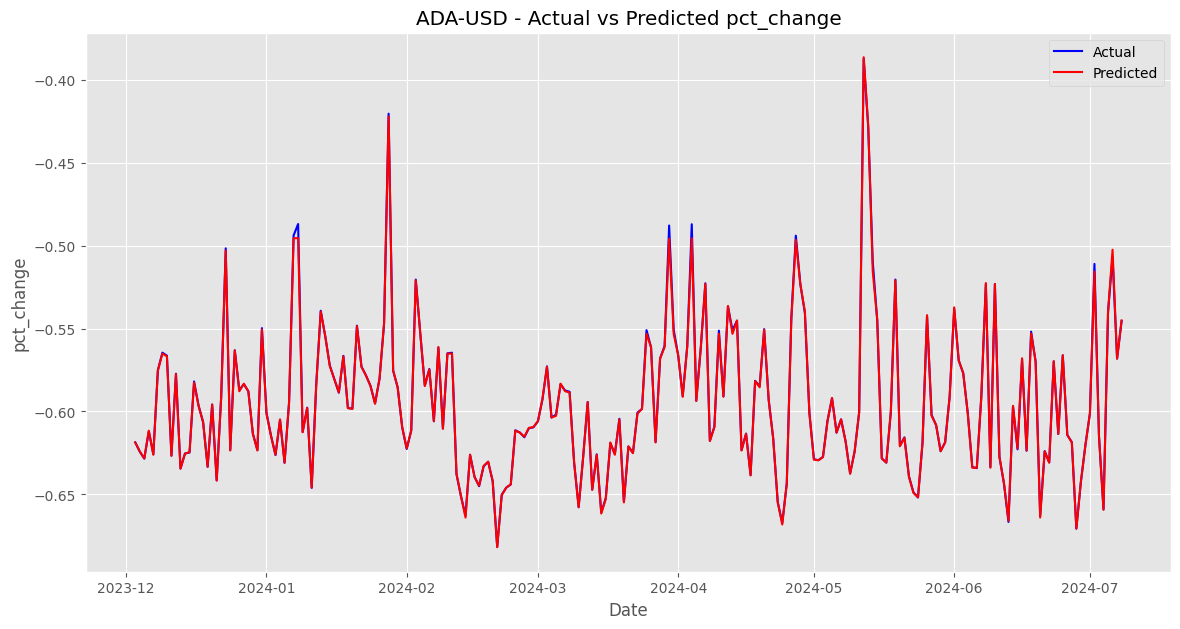

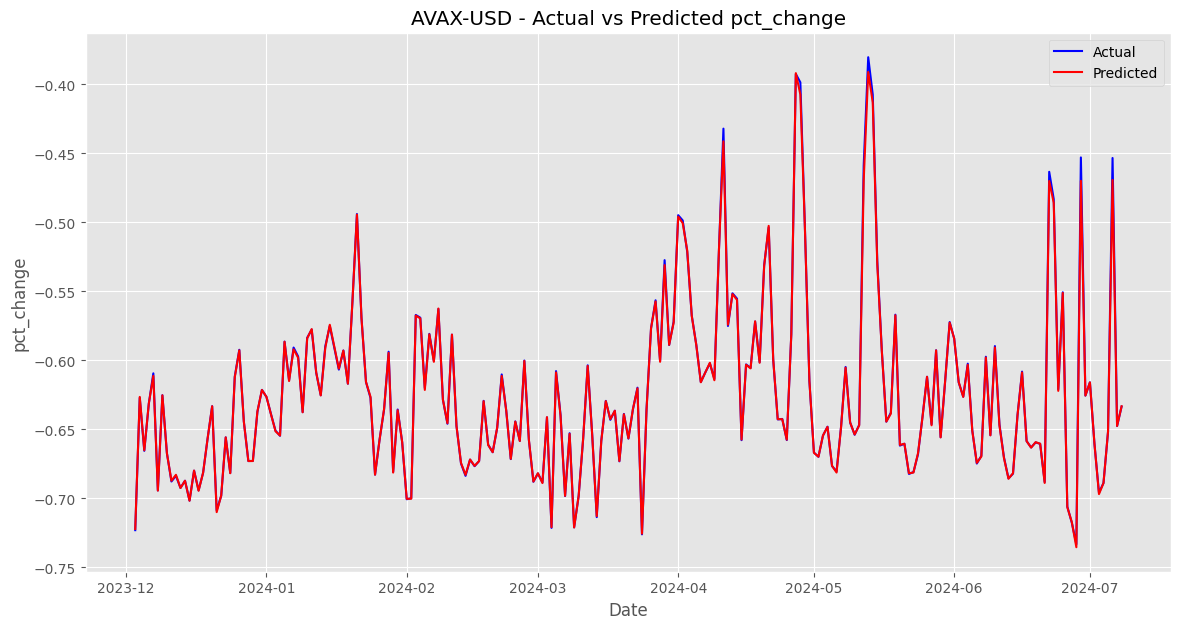

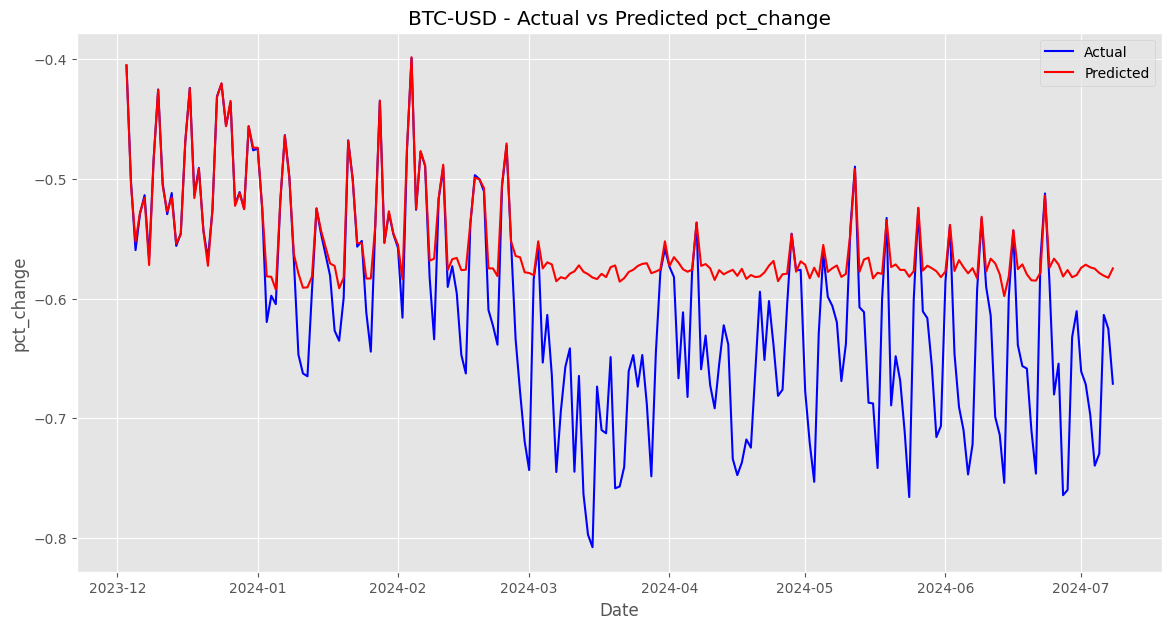

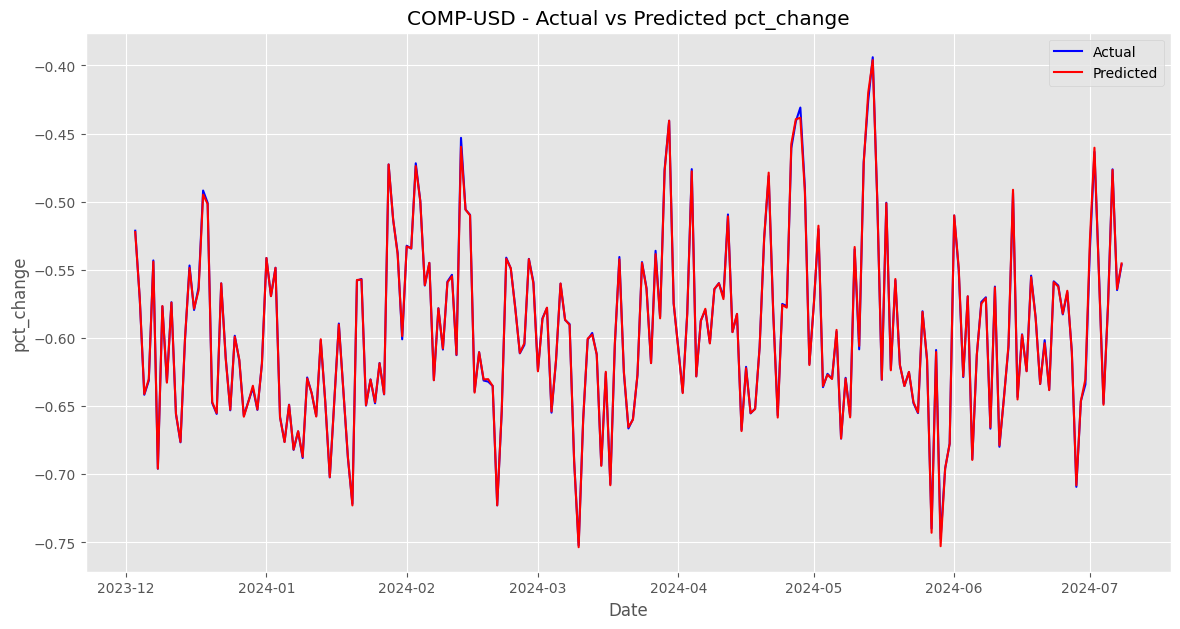

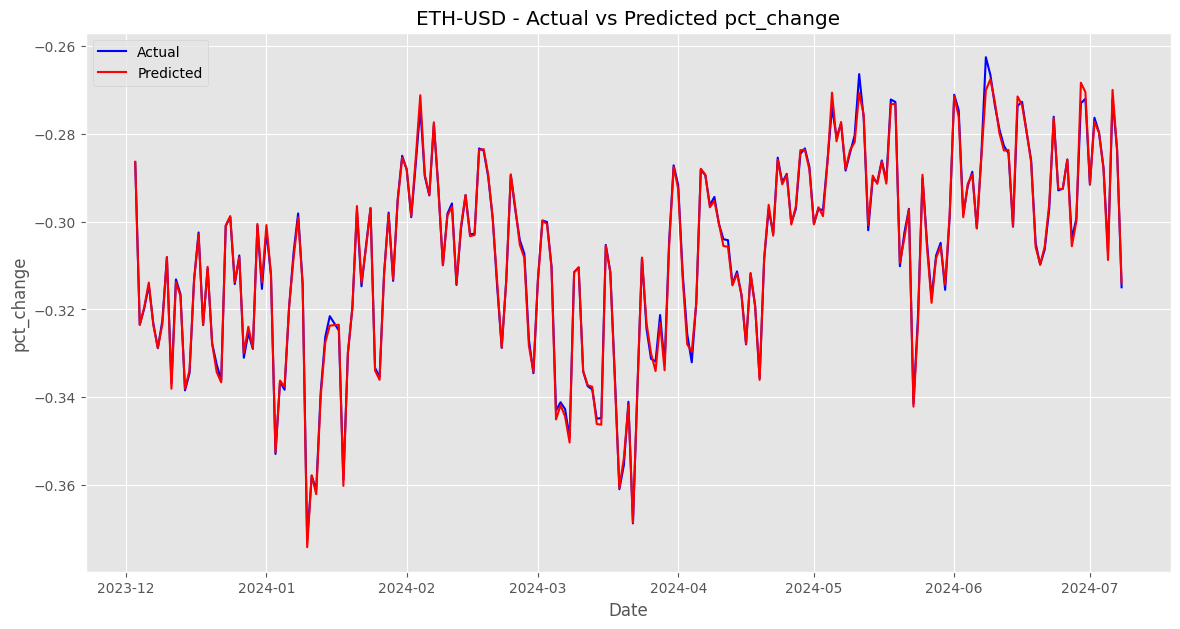

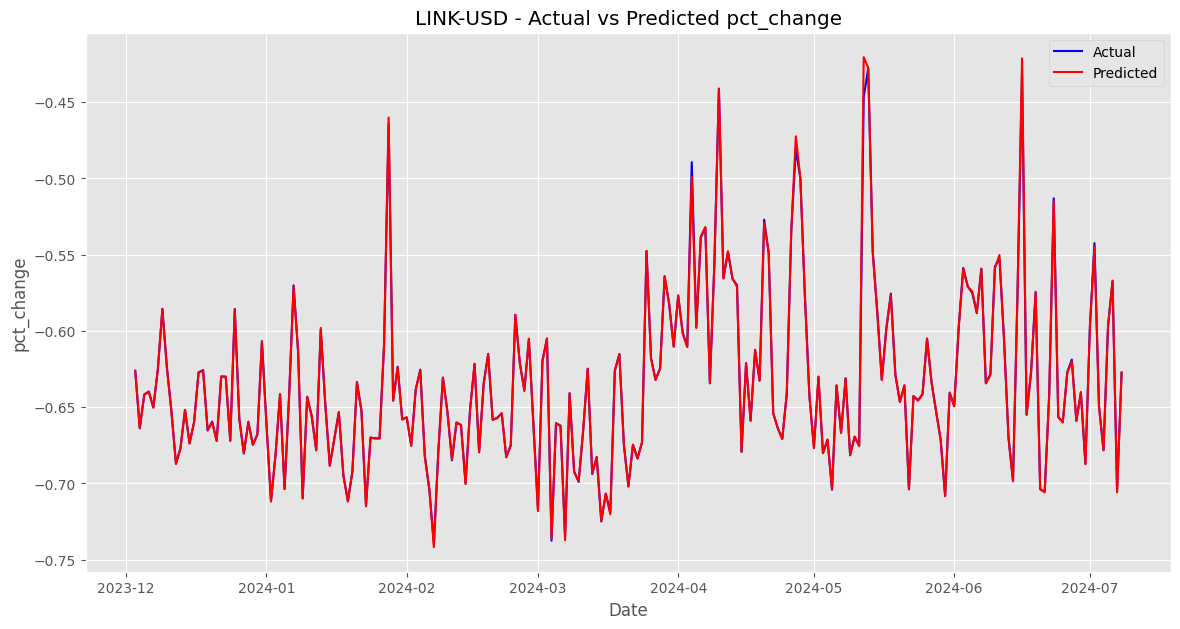

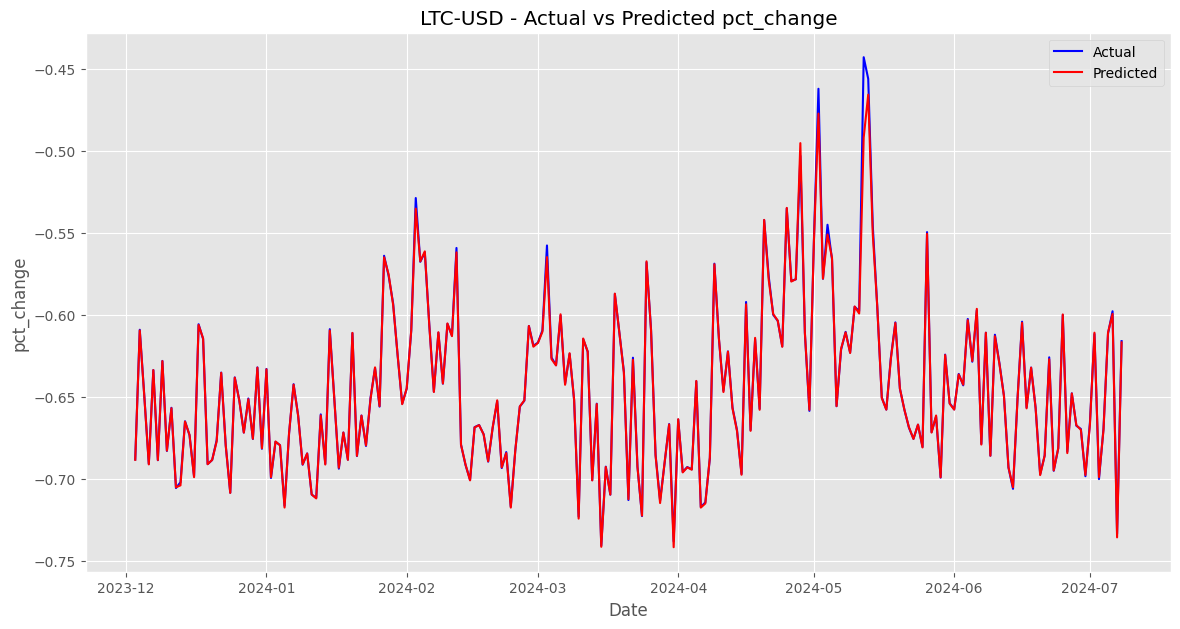

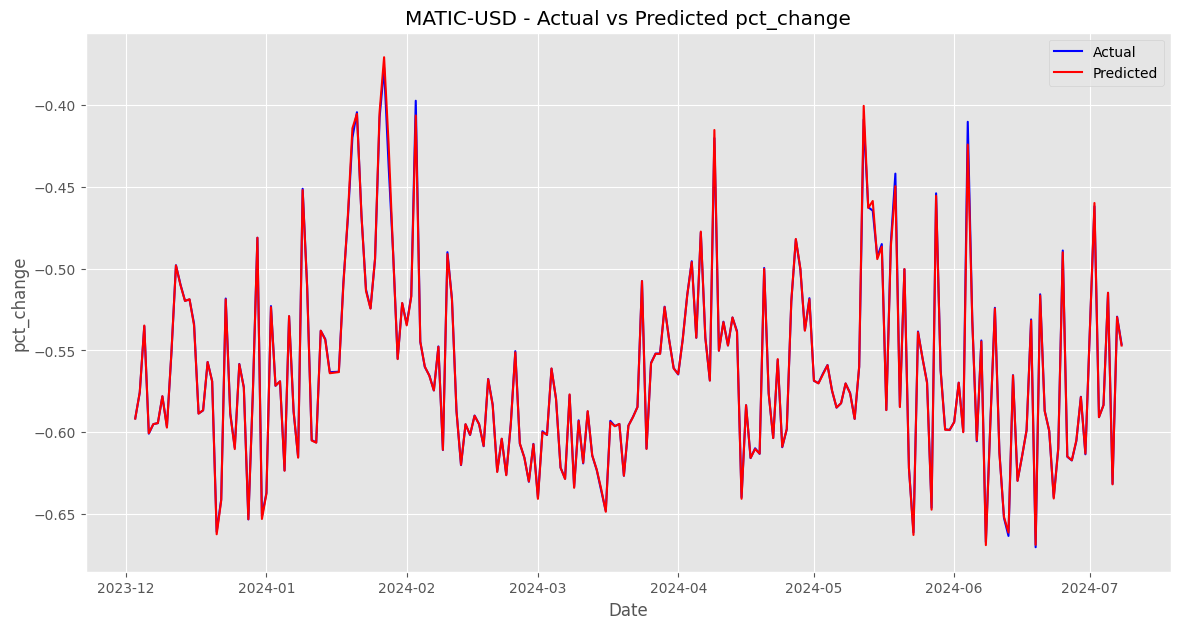

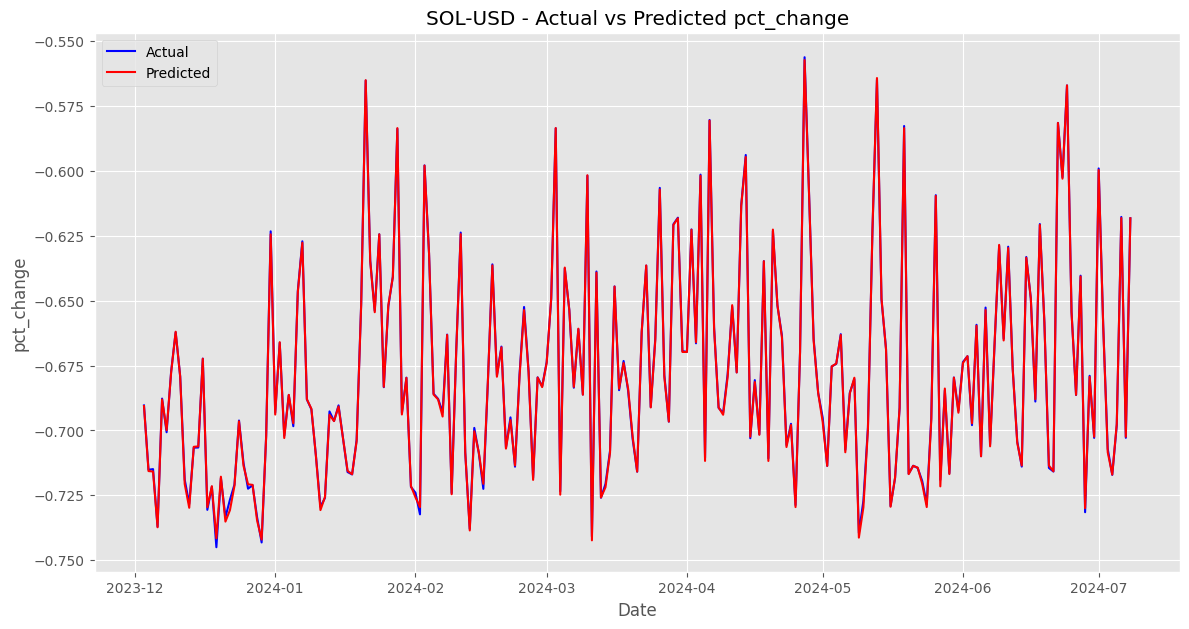

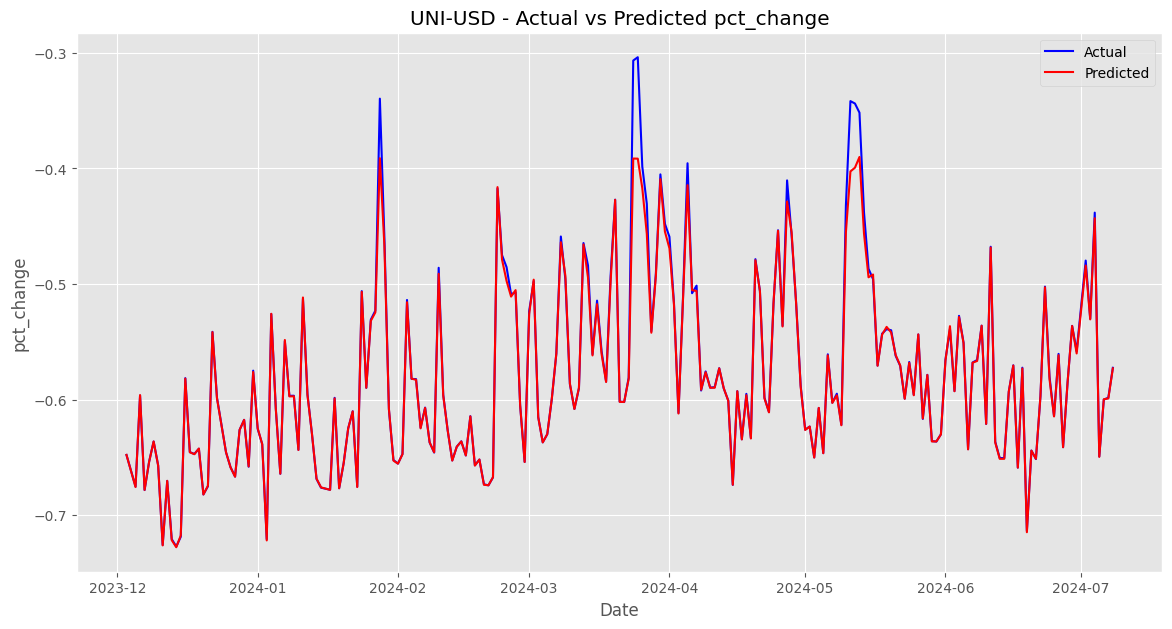

,Train MSE,Train RMSE,Train MAE,Train R-Squared,Train MAPE,Test MSE,Test RMSE,Test MAE,Test R-Squared,Test MAPE
ADA-USD,7.949796e-08,0.000282,0.000190,0.999966,0.000327,1.572596e-06,0.001254,0.000508,0.999232,0.000943
AVAX-USD,1.273413e-07,0.000357,0.000250,0.999965,0.000407,5.041069e-06,0.002245,0.000789,0.998757,0.001563
BTC-USD,1.199818e-07,0.000346,0.000255,0.999970,0.000667,6.585703e-03,0.081152,0.055689,0.156209,0.080582
COMP-USD,3.808471e-07,0.000617,0.000477,0.999913,0.000785,1.999091e-06,0.001414,0.000886,0.999524,0.001588
ETH-USD,2.465804e-07,0.000497,0.000374,0.999987,0.000805,1.234397e-06,0.001111,0.000743,0.997454,0.002456
LINK-USD,1.132581e-07,0.000337,0.000221,0.999961,0.000359,4.810418e-06,0.002193,0.000631,0.998507,0.001173
LTC-USD,1.814015e-07,0.000426,0.000315,0.999907,0.000487,1.383445e-05,0.003719,0.000918,0.994597,0.001703
MATIC-USD,1.129874e-07,0.000336,0.000230,0.999957,0.000420,3.602551e-06,0.001898,0.000731,0.998905,0.001529
SOL-USD,4.390750e-07,0.000663,0.000420,0.999929,0.000756,6.573750e-07,0.000811,0.000568,0.999610,0.000823
UNI-USD,1.200522e-07,0.000346,0.000243,0.999964,0.000397,1.341162e-04,0.011581,0.003220,0.980041,0.008495


In [32]:
# Define a function to fit the model and evaluate it
def fit_and_evaluate_model(train_df, test_df, best_params_dict):
    results = {}
    
    for product_id, params in best_params_dict.items():
        # Prepare data
        train_group = train_df[train_df['product_id'] == product_id]
        test_group = test_df[test_df['product_id'] == product_id]
        
        X_train = train_group.drop(columns=['pct_change', 'product_id', 'day_of_week'])
        y_train = train_group['pct_change']
        X_test = test_group.drop(columns=['pct_change', 'product_id', 'day_of_week'])
        y_test = test_group['pct_change']
        
        # Initialize and fit the model
        xgbr = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **params)
        xgbr.fit(X_train, y_train)
        
        # Predict and evaluate on the training set
        y_train_pred = xgbr.predict(X_train)
        train_mse = mean_squared_error(y_train, y_train_pred)
        train_rmse = np.sqrt(train_mse)
        train_mae = mean_absolute_error(y_train, y_train_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
        
        # Predict and evaluate on the test set
        y_test_pred = xgbr.predict(X_test)
        test_mse = mean_squared_error(y_test, y_test_pred)
        test_rmse = np.sqrt(test_mse)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
        
        # Store the results
        results[product_id] = {
            'Train MSE': train_mse,
            'Train RMSE': train_rmse,
            'Train MAE': train_mae,
            'Train R-Squared': train_r2,
            'Train MAPE': train_mape,
            'Test MSE': test_mse,
            'Test RMSE': test_rmse,
            'Test MAE': test_mae,
            'Test R-Squared': test_r2,
            'Test MAPE': test_mape,
        }
        
        # Plot the actual vs predicted for the test set
        plt.figure(figsize=(14, 7))
        plt.plot(y_test.index, y_test, label='Actual', color='blue')
        plt.plot(y_test.index, y_test_pred, label='Predicted', color='red')
        plt.title(f'{product_id} - Actual vs Predicted pct_change')
        plt.xlabel('Date')
        plt.ylabel('pct_change')
        plt.legend()
        plt.show()
    
    return results

# Fit the model and evaluate
xgboost_results = fit_and_evaluate_model(train_df_scaled, test_df_scaled, best_params_dict)

# Display the results
results_df = pd.DataFrame(xgboost_results).T
results_df = results_df[['Train MSE', 'Train RMSE', 'Train MAE', 'Train R-Squared', 'Train MAPE', 'Test MSE', 'Test RMSE', 'Test MAE', 'Test R-Squared', 'Test MAPE']]
results_df


### Evaluate All Models on the Test Set

This process evaluates various models, including Linear Regression, SVC, Random Forest Regressor, XGBoost Regressor, and Ridge Regression, on the test set for each `product_id`. The `evaluate_models` function fits each model, predicts on the test set, and calculates performance metrics (MSE, RMSE, MAE, R-Squared, and MAPE). ARIMA is handled separately. The results are compiled into a DataFrame, which is then used to display model performance. An interactive widget allows users to select a `product_id` and view the results, highlighting the top-performing model based on R-Squared. This comprehensive evaluation ensures effective comparison and selection of models for each product subset.

In [33]:
# Define the models
models = {
    'Linear Regression': LinearRegression(),
    'SVC': SVR(),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost Regressor': xgb.XGBRegressor(random_state=42),
    'Ridge Regression': Ridge(),
    'ARIMA': None,  # ARIMA will be handled separately
}

# Define the evaluation metrics
metrics = {
    'MSE': mean_squared_error,
    'RMSE': lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False),
    'MAE': mean_absolute_error,
    'R-Squared': r2_score,
    'MAPE': mean_absolute_percentage_error
}

# Define a function to evaluate the models
def evaluate_models(train_df, test_df, best_params):
    results = []

    for product_id in train_df['product_id'].unique():
        train_data = train_df[train_df['product_id'] == product_id]
        test_data = test_df[test_df['product_id'] == product_id]

        X_train = train_data.drop(columns=['pct_change', 'product_id'])
        y_train = train_data['pct_change']
        X_test = test_data.drop(columns=['pct_change', 'product_id'])
        y_test = test_data['pct_change']

        for model_name, model in models.items():
            if model_name == 'ARIMA':
                # Handle ARIMA separately
                continue

            if model_name == 'XGBoost Regressor':
                # Use the best parameters found during hypertuning
                model = xgb.XGBRegressor(**best_params[product_id])

            # Fit the model
            model.fit(X_train, y_train)

            # Predict on the test set
            y_pred = model.predict(X_test)

            # Calculate the metrics
            metrics_values = [metrics[metric](y_test, y_pred) for metric in metrics]
            results.append([product_id, model_name] + metrics_values)

    return results

# Perform the evaluation
best_params = {
    'ADA-USD': {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0},
    'AVAX-USD': {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.6},
    'BTC-USD': {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8},
    'COMP-USD': {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.6},
    'ETH-USD': {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8},
    'LINK-USD': {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8},
    'LTC-USD': {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8},
    'MATIC-USD': {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0},
    'SOL-USD': {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.6},
    'UNI-USD': {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.6}
}

results = evaluate_models(train_df_scaled, test_df_scaled, best_params)

# Create a DataFrame to store the results
results_df = pd.DataFrame(results, columns=['Product ID', 'Model', 'MSE', 'RMSE', 'MAE', 'R-Squared', 'MAPE'])

# Display the results
results_df.head()

,Product ID,Model,MSE,RMSE,MAE,R-Squared,MAPE
0,ADA-USD,Linear Regression,9.039601e-30,3.006593e-15,2.319500e-15,1.000000,3.946697e-15
1,ADA-USD,SVC,1.900746e-03,4.359754e-02,3.840493e-02,0.071716,6.366869e-02
2,ADA-USD,Random Forest Regressor,1.846412e-07,4.296989e-04,1.949591e-04,0.999910,3.688640e-04
3,ADA-USD,XGBoost Regressor,1.677340e-06,1.295121e-03,5.128077e-04,0.999181,9.478329e-04
4,ADA-USD,Ridge Regression,9.984154e-07,9.992074e-04,8.057854e-04,0.999512,1.366523e-03


In [34]:
# Function to display model results for a selected product ID with highlighted top model
def display_model_results(product_id):
    display_df = results_df[results_df['Product ID'] == product_id].sort_values(by='R-Squared', ascending=False)
    display_df = display_df[['Model'] + [col for col in display_df.columns if col != 'Model']]  # Move 'Model' to the first column
    # Highlight the top-performing model
    display_df = display_df.style.apply(lambda x: ['background: lightgreen' if x.name == 0 else '' for i in x], axis=1)
    display(display_df)

# Create a dropdown widget for product_id selection
product_id_dropdown = widgets.Dropdown(
    options=results_df['Product ID'].unique(),
    description='Product ID:',
    disabled=False,
)

# Display the dropdown and link it to the display_model_results function
widgets.interactive(display_model_results, product_id=product_id_dropdown)

interactive(children=(Dropdown(description='Product ID:', options=('ADA-USD', 'AVAX-USD', 'BTC-USD', 'COMP-USD…

### Hyperparameter Tuning and Cross-Validation for Ridge Regression

This process involves hyperparameter tuning for Ridge Regression using TimeSeriesSplit for cross-validation. The `ridge_params` defines a range of alpha values to be tested. For each `product_id` in the training set, the data is split, and GridSearchCV is used to find the best parameters for Ridge Regression. The best parameters and models are stored in dictionaries (`best_params_ridge` and `best_models_ridge`), ensuring each product subset has an optimized Ridge Regression model. This method guarantees effective and tailored hyperparameter configurations for improved model performance.

In [35]:
# Define a range of hyperparameters for Ridge Regression
ridge_params = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}

# Set up TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)
# Initialize dictionaries to store best parameters and models for each product_id
best_params_ridge = {}
best_models_ridge = {}

# Loop through each product_id group in the training set
for product_id, group in train_df_scaled.groupby('product_id'):
    X_train = group.drop(columns=['product_id', 'pct_change'])
    y_train = group['pct_change']

    # Initialize Ridge Regression and GridSearchCV
    ridge = Ridge()
    grid_search = GridSearchCV(estimator=ridge, param_grid=ridge_params, cv=tscv, scoring='neg_mean_squared_error')
    
    # Fit GridSearchCV on the training data
    grid_search.fit(X_train, y_train)
    
    # Store the best parameters and best model
    best_params_ridge[product_id] = grid_search.best_params_
    best_models_ridge[product_id] = grid_search.best_estimator_
    
    print(f"Best parameters for {product_id}: {grid_search.best_params_}")

# The `best_params_ridge` and `best_models_ridge` dictionaries now contain the best parameters and models for each product_id

Best parameters for ADA-USD: {'alpha': 0.01}
Best parameters for AVAX-USD: {'alpha': 0.01}
Best parameters for BTC-USD: {'alpha': 0.01}
Best parameters for COMP-USD: {'alpha': 0.01}
Best parameters for ETH-USD: {'alpha': 0.01}
Best parameters for LINK-USD: {'alpha': 0.01}
Best parameters for LTC-USD: {'alpha': 0.01}
Best parameters for MATIC-USD: {'alpha': 0.01}
Best parameters for SOL-USD: {'alpha': 0.01}
Best parameters for UNI-USD: {'alpha': 0.01}


### Evaluate the Ridge Regression Models on the Test Set

This process involves evaluating the Ridge Regression models on the test set. The `evaluate_model` function calculates performance metrics (MSE, RMSE, MAE, R-Squared, and MAPE). For each `product_id`, the best Ridge model is used to make predictions on the test set, and the results are stored in a dictionary. The results are printed for each `product_id`, and actual vs. predicted values are plotted for visualization. Additionally, a function creates a comparison DataFrame of actual vs. predicted values for the last 7 days for a selected `product_id`, and an interactive widget allows users to select a `product_id` to view the comparison. This ensures comprehensive evaluation and visualization of the Ridge model's performance on the test set.

In [36]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    return mse, rmse, mae, r2, mape

In [37]:
# Initialize dictionaries to store the evaluation results
ridge_test_results = {}

# Loop through each product_id group in the test set and evaluate the corresponding Ridge model
for product_id, group in test_df_scaled.groupby('product_id'):
    X_test = group.drop(columns=['product_id', 'pct_change'])
    y_test = group['pct_change']
    
    best_model = best_models_ridge[product_id]
    
    mse, rmse, mae, r2, mape = evaluate_model(best_model, X_test, y_test)
    
    ridge_test_results[product_id] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R-Squared': r2,
        'MAPE': mape
    }

# Print the evaluation results
for product_id, metrics in ridge_test_results.items():
    print(f"\nEvaluation results for {product_id}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")



Evaluation results for ADA-USD:
MSE: 5.224203214768789e-08
RMSE: 0.00022856515952281067
MAE: 0.0001641245592028043
R-Squared: 0.9999744860958287
MAPE: 0.000274861465818007

Evaluation results for AVAX-USD:
MSE: 5.643874268740759e-09
RMSE: 7.51257230829811e-05
MAE: 5.9640624343043063e-05
R-Squared: 0.9999986085195526
MAPE: 9.652752515138366e-05

Evaluation results for BTC-USD:
MSE: 1.0352574671706041e-06
RMSE: 0.001017476027811272
MAE: 0.0007998776405170274
R-Squared: 0.9998673579233714
MAPE: 0.001315752609683901

Evaluation results for COMP-USD:
MSE: 1.7562788285547068e-07
RMSE: 0.00041907980487667344
MAE: 0.00025049330465238634
R-Squared: 0.9999581633495197
MAPE: 0.0004191043792413473

Evaluation results for ETH-USD:
MSE: 7.142928574496083e-09
RMSE: 8.451584806707014e-05
MAE: 6.477289108253054e-05
R-Squared: 0.9999852682684551
MAPE: 0.00020664836353333503

Evaluation results for LINK-USD:
MSE: 1.3210863162452373e-10
RMSE: 1.149385190545466e-05
MAE: 9.267354811661815e-06
R-Squared: 0.

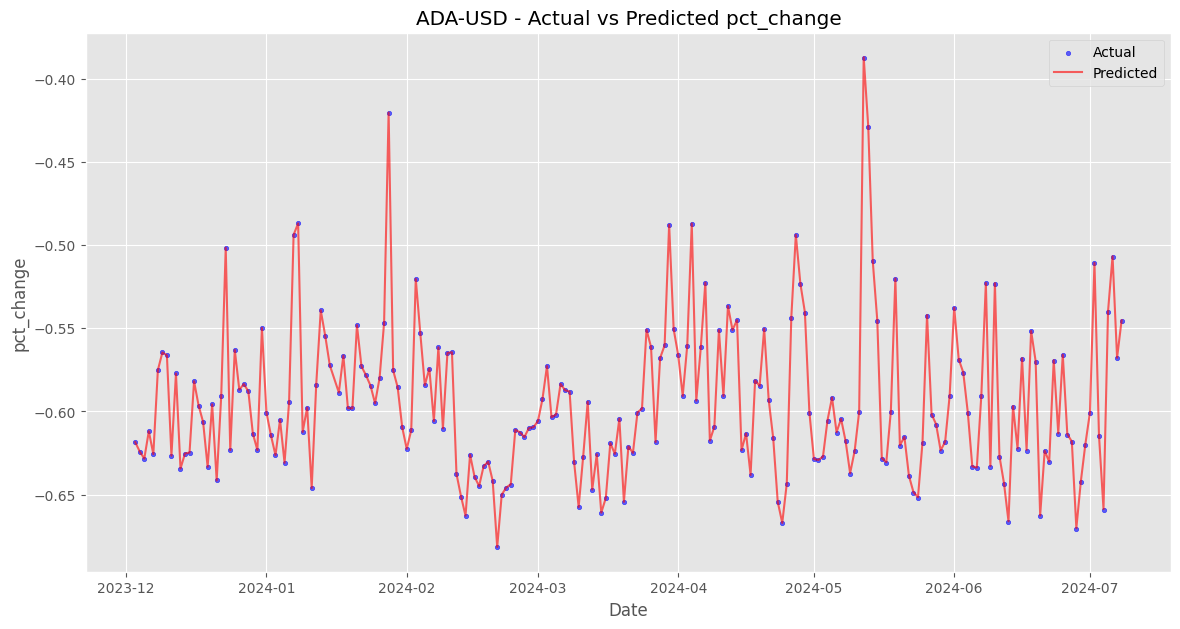

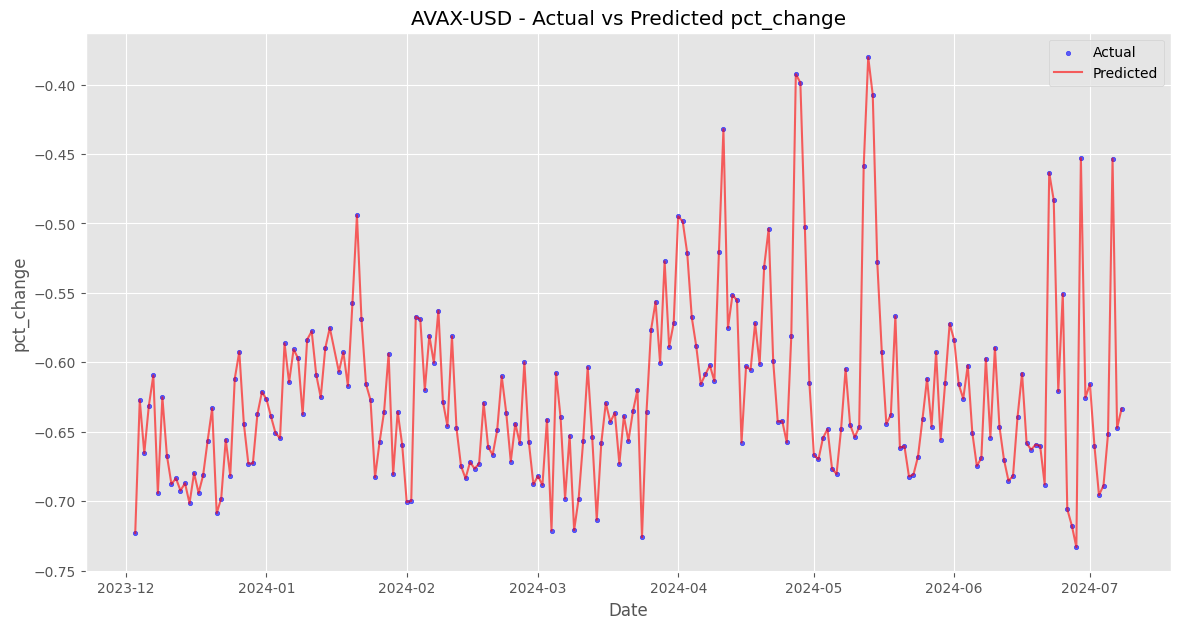

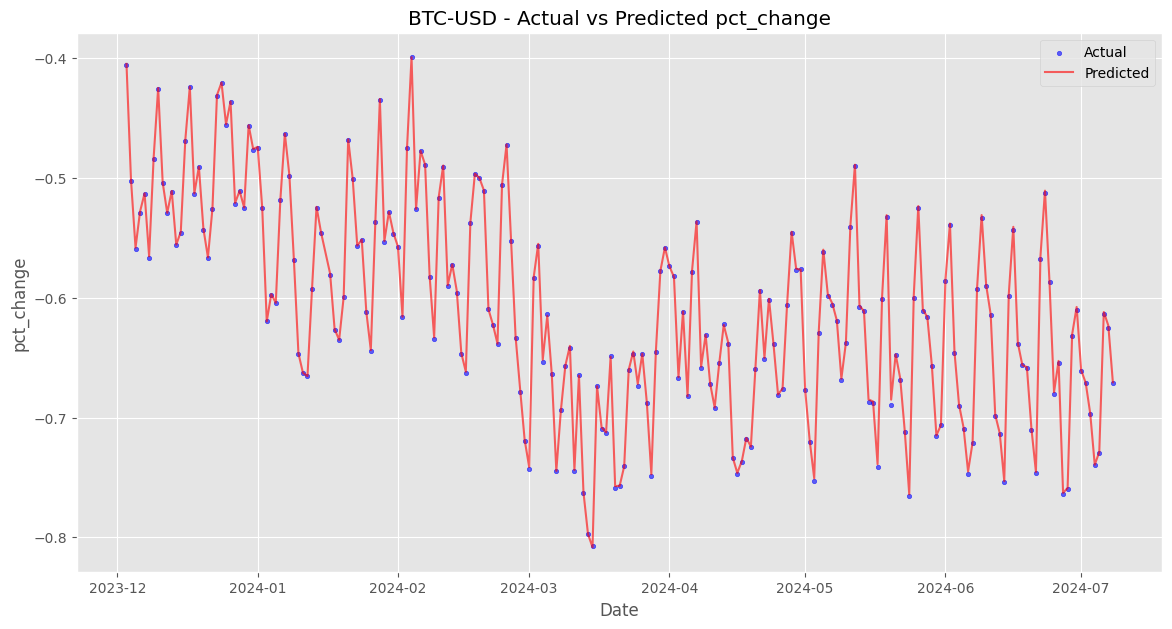

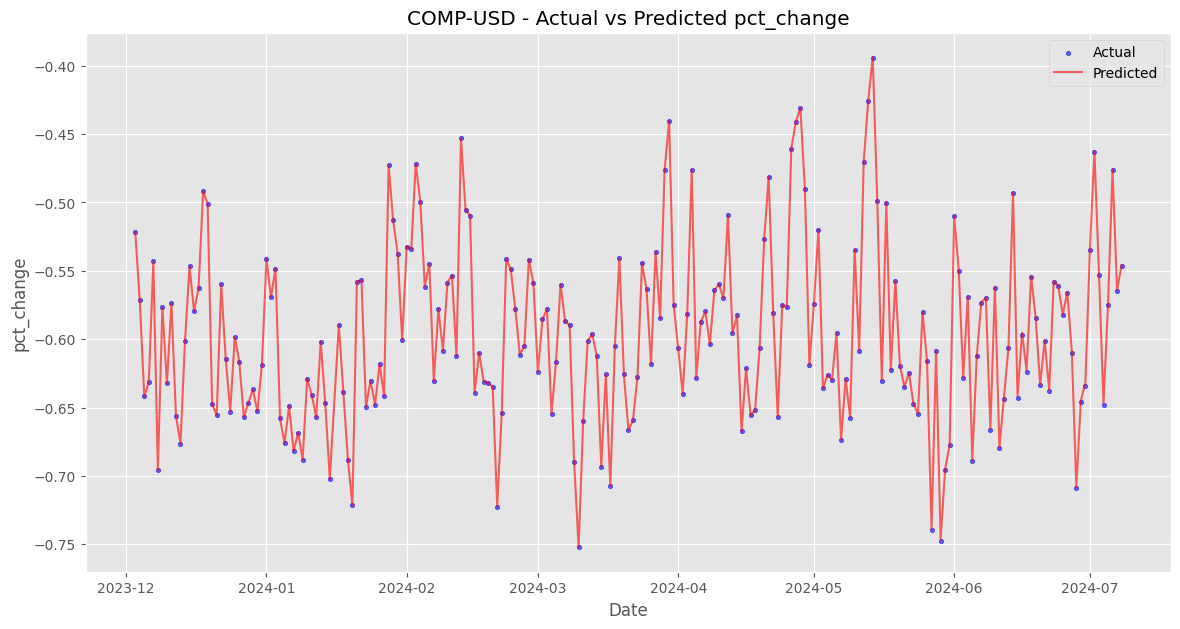

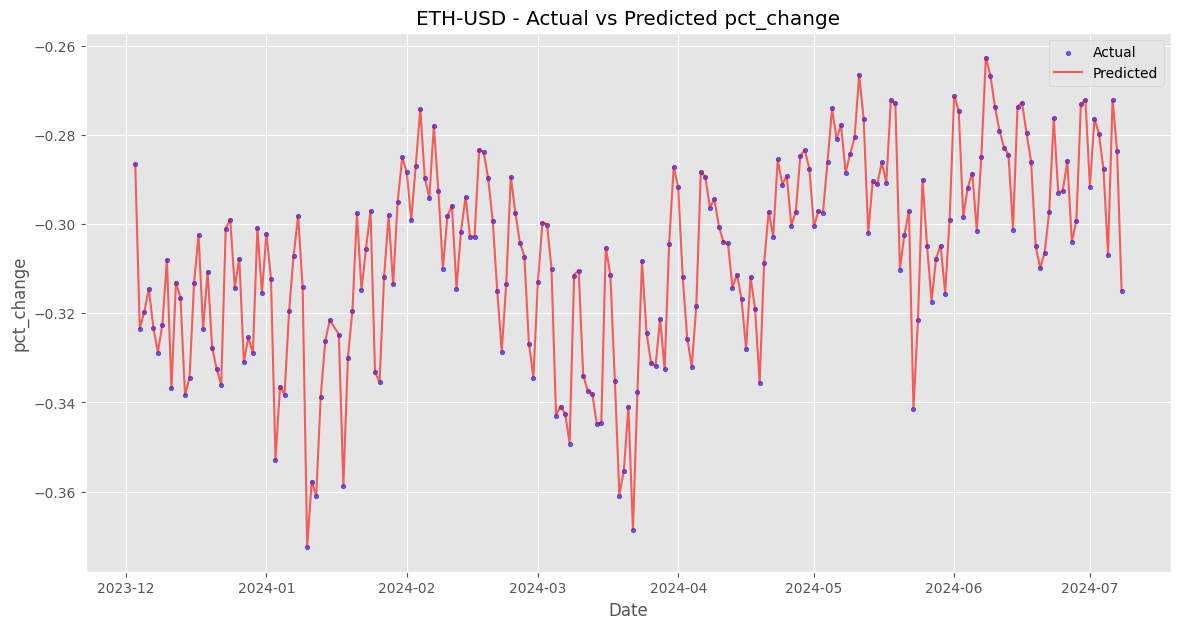

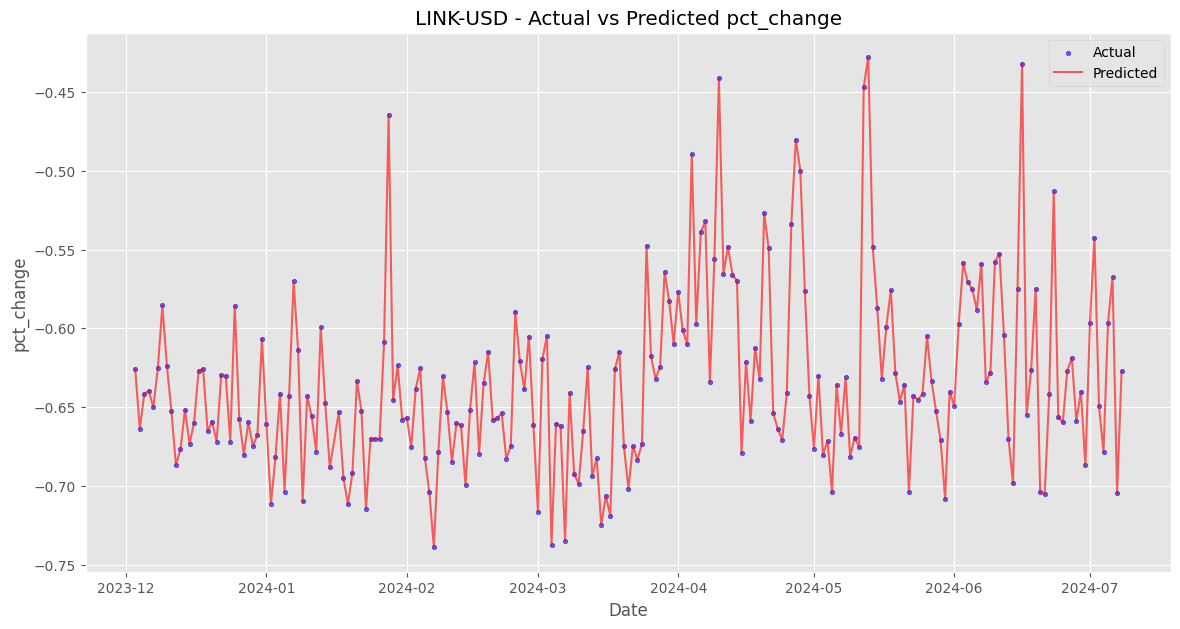

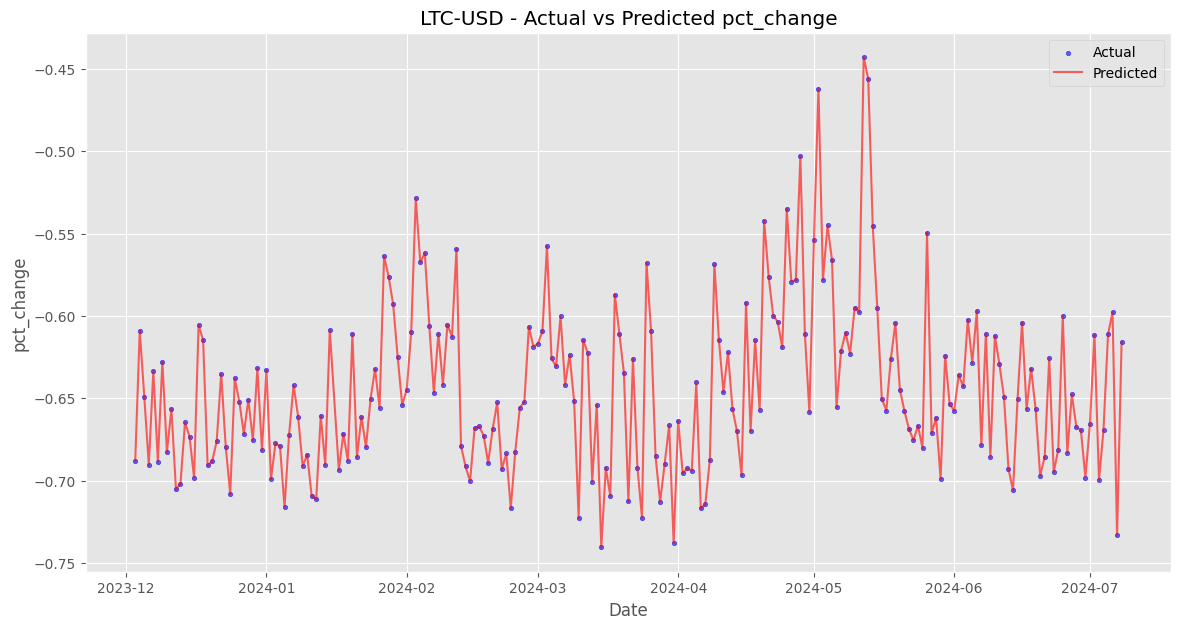

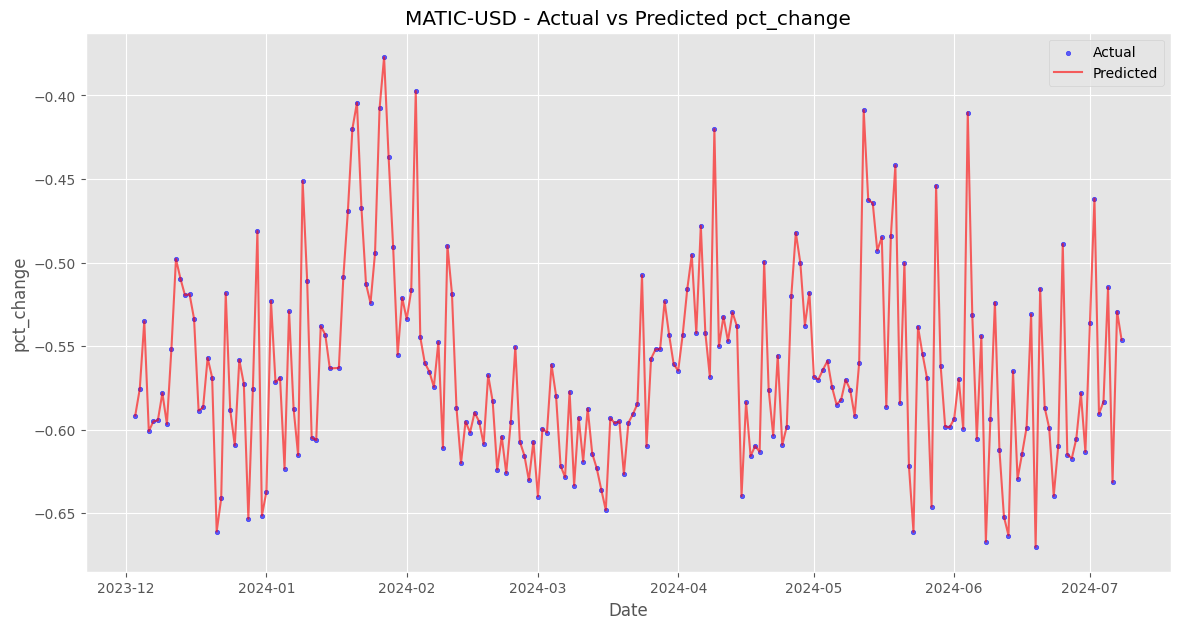

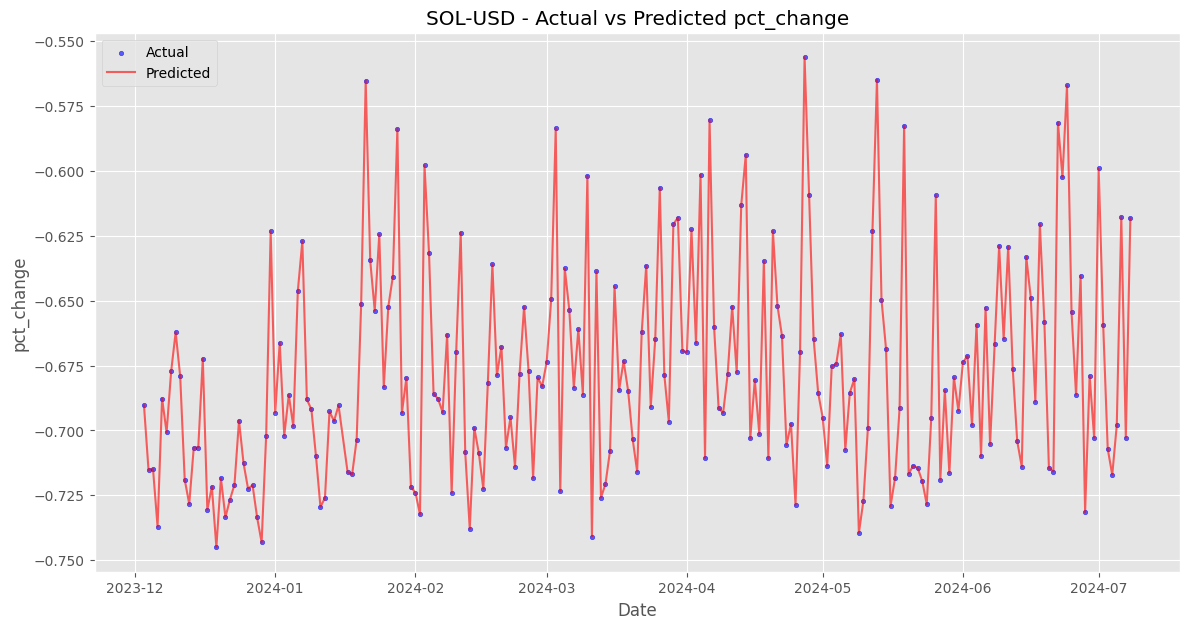

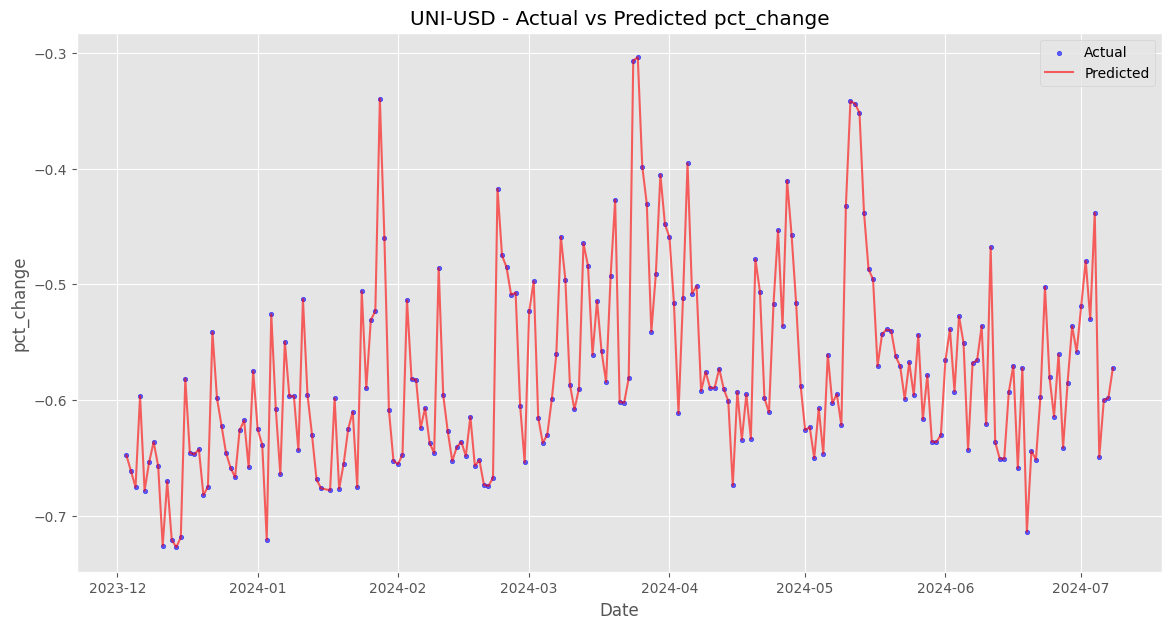

,Train MSE,Train RMSE,Train MAE,Train R-Squared,Train MAPE,Test MSE,Test RMSE,Test MAE,Test R-Squared,Test MAPE
ADA-USD,2.325218e-08,0.000152,0.000112,0.999990,0.000185,5.224203e-08,0.000229,0.000164,0.999974,0.000275
AVAX-USD,1.628485e-08,0.000128,0.000087,0.999996,0.000138,5.643874e-09,0.000075,0.000060,0.999999,0.000097
BTC-USD,3.928613e-08,0.000198,0.000150,0.999990,0.000379,1.035257e-06,0.001017,0.000800,0.999867,0.001316
COMP-USD,5.554485e-08,0.000236,0.000170,0.999987,0.000273,1.756279e-07,0.000419,0.000250,0.999958,0.000419
ETH-USD,2.506741e-08,0.000158,0.000108,0.999999,0.000190,7.142929e-09,0.000085,0.000065,0.999985,0.000207
LINK-USD,1.540522e-10,0.000012,0.000010,1.000000,0.000016,1.321086e-10,0.000011,0.000009,1.000000,0.000015
LTC-USD,1.385118e-09,0.000037,0.000028,0.999999,0.000042,9.335181e-10,0.000031,0.000023,1.000000,0.000035
MATIC-USD,2.441084e-09,0.000049,0.000035,0.999999,0.000063,6.551294e-09,0.000081,0.000060,0.999998,0.000104
SOL-USD,1.899411e-10,0.000014,0.000011,1.000000,0.000018,1.553661e-10,0.000012,0.000010,1.000000,0.000015
UNI-USD,2.737375e-10,0.000017,0.000013,1.000000,0.000020,4.763748e-10,0.000022,0.000018,1.000000,0.000034


In [38]:
# Define a function to fit the Ridge model and evaluate it
def fit_and_evaluate_ridge(train_df, test_df, best_params_dict):
    results = {}
    
    for product_id, params in best_params_dict.items():
        alpha = params['alpha']  # Extract the alpha value
        
        # Prepare data
        train_group = train_df[train_df['product_id'] == product_id]
        test_group = test_df[test_df['product_id'] == product_id]
        
        X_train = train_group.drop(columns=['pct_change', 'product_id'])
        y_train = train_group['pct_change']
        X_test = test_group.drop(columns=['pct_change', 'product_id'])
        y_test = test_group['pct_change']
        
        # Initialize and fit the Ridge model
        ridge = Ridge(alpha=alpha, random_state=42)
        ridge.fit(X_train, y_train)
        
        # Predict and evaluate on the training set
        y_train_pred = ridge.predict(X_train)
        train_mse = mean_squared_error(y_train, y_train_pred)
        train_rmse = np.sqrt(train_mse)
        train_mae = mean_absolute_error(y_train, y_train_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
        
        # Predict and evaluate on the test set
        y_test_pred = ridge.predict(X_test)
        test_mse = mean_squared_error(y_test, y_test_pred)
        test_rmse = np.sqrt(test_mse)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
        
        # Store the results
        results[product_id] = {
            'Train MSE': train_mse,
            'Train RMSE': train_rmse,
            'Train MAE': train_mae,
            'Train R-Squared': train_r2,
            'Train MAPE': train_mape,
            'Test MSE': test_mse,
            'Test RMSE': test_rmse,
            'Test MAE': test_mae,
            'Test R-Squared': test_r2,
            'Test MAPE': test_mape,
        }
        
        # Plot the actual vs predicted for the test set
        plt.figure(figsize=(14, 7))
        plt.scatter(y_test.index, y_test, label='Actual', color='blue', alpha=0.6, s=10)
        plt.plot(y_test.index, y_test_pred, label='Predicted', color='red', alpha=0.6)
        plt.title(f'{product_id} - Actual vs Predicted pct_change')
        plt.xlabel('Date')
        plt.ylabel('pct_change')
        plt.legend()
        plt.show()
    
    return results

# Fit the Ridge model and evaluate
ridge_results = fit_and_evaluate_ridge(train_df_scaled, test_df_scaled, best_params_ridge)

# Display the results
results_df_ridge = pd.DataFrame(ridge_results).T
results_df_ridge = results_df_ridge[['Train MSE', 'Train RMSE', 'Train MAE', 'Train R-Squared', 'Train MAPE', 'Test MSE', 'Test RMSE', 'Test MAE', 'Test R-Squared', 'Test MAPE']]

results_df_ridge


In [39]:
# Function to create a DataFrame with actual vs. predicted values for the last 7 days for a given product ID
def create_comparison_df(product_id, train_df, test_df, model, params):
    train_group = train_df[train_df['product_id'] == product_id]
    test_group = test_df[test_df['product_id'] == product_id]
    
    X_train = train_group.drop(columns=['pct_change', 'product_id', 'day_of_week'])
    y_train = train_group['pct_change']
    X_test = test_group.drop(columns=['pct_change', 'product_id', 'day_of_week'])
    y_test = test_group['pct_change']
    
    model.set_params(**params)
    model.fit(X_train, y_train)
    
    y_test_pred = model.predict(X_test)
    
    comparison_df = pd.DataFrame({
        'Date': y_test.index,
        'Actual': y_test.values,
        'Predicted': y_test_pred
    }).set_index('Date')
    
    # Focus on the last 7 days of the test set
    comparison_df_last_7 = comparison_df.tail(7)
    
    return comparison_df_last_7

# Function to update the table display
def update_table(product_id):
    comparison_df = create_comparison_df(product_id, train_df_scaled, test_df_scaled, Ridge(random_state=42), best_params_ridge[product_id])
    with output:
        output.clear_output()
        display(comparison_df)

# Create dropdown widget for product ID selection
product_id_dropdown = widgets.Dropdown(
    options=train_df_scaled['product_id'].unique(),
    description='Product ID:',
    disabled=False,
)

# Create a display area for the table
output = widgets.Output()

# Set the callback for when the dropdown value changes
product_id_dropdown.observe(lambda change: update_table(change.new), names='value')

# Display the dropdown and the output area
display(product_id_dropdown, output)

# Initialize the display with the first product ID
update_table(product_id_dropdown.value)


Dropdown(description='Product ID:', options=('ADA-USD', 'AVAX-USD', 'BTC-USD', 'COMP-USD', 'ETH-USD', 'LINK-US…

Output()

### Loading the Data from Last Week
This code snippet loads the dataset from the last week, processes it, and prepares it for forecasting using Ridge Regression models. It ensures the data is clean and ready for analysis.

In [40]:
# Define the path to the dataset
file_path1 = 'Cleaned_Data/test_weekago_cleaned.csv'

# Load the dataset
last_week = pd.read_csv(file_path1)
last_week.head()

# Drop the 'Unnamed: 0' column
last_week.drop(columns=['Unnamed: 0'], inplace=True)
# Convert 'time' to datetime
last_week['time'] = pd.to_datetime(last_week['time'])

# Verify data types
print(last_week.dtypes)

# Group the data by 'product_id' and find the minimum 'time' for each group
start_date_last_week = last_week.groupby('product_id')['time'].min()

# Print the start dates for each product ID
print(start_date_last_week)

# Verify the dataset structure
print("last_week dataset structure:")
print(last_week.head())

# Verify the minimum date in the last_week dataset
start_date_last_week = last_week.groupby('product_id')['time'].min()
print("\nStart dates for each product ID in last_week dataset:")
print(start_date_last_week)

time             datetime64[ns]
low                     float64
high                    float64
open                    float64
close                   float64
volume                  float64
price_change            float64
average_price           float64
volatility              float64
product_id               object
day_of_week               int64
pct_change              float64
dtype: object
product_id
ADA-USD     2024-07-12
AVAX-USD    2024-07-12
BTC-USD     2024-07-12
COMP-USD    2024-07-12
ETH-USD     2024-07-12
LINK-USD    2024-07-12
LTC-USD     2024-07-12
MATIC-USD   2024-07-12
SOL-USD     2024-07-12
UNI-USD     2024-07-12
Name: time, dtype: datetime64[ns]
last_week dataset structure:
        time       low      high      open     close        volume  \
0 2024-07-18  63904.27  65117.16  64085.82  64646.11    883.246813   
1 2024-07-17  63853.99  66139.00  65086.55  64085.81  10647.658257   
2 2024-07-16  62410.33  65405.89  64757.16  65088.99  14691.920023   
3 2024-07-15  6066

### Forecast the Next 7 Days Using the Ridge Model
This code snippet prepares the cleaned dataset, creates lag features, and forecasts the next 7 days using Ridge Regression models optimized with hyperparameters.

In [41]:
# Ensure 'time' is of datetime type and set it as the index
df_cleaned.reset_index(inplace=True)
df_cleaned['time'] = pd.to_datetime(df_cleaned['time'])
df_cleaned.set_index('time', inplace=True)

# Create lag features
for lag in range(1, 8):  # Creating lag features for the past 7 days
    df_cleaned[f'pct_change_lag_{lag}'] = df_cleaned['pct_change'].shift(lag)

# Drop missing values after creating lags
df_cleaned.dropna(inplace=True)

# Verify the creation of lag features
print("Sample data with lag features:")
print(df_cleaned.head())

Sample data with lag features:
           product_id        volume  price_change  volatility  pct_change  \
time                                                                        
2021-07-23    ADA-USD  3.632470e+07        0.0221    5.416485    0.018637   
2021-07-24    ADA-USD  3.445630e+07        0.0265    4.410659    0.022022   
2021-07-25    ADA-USD  2.849963e+07       -0.0046    4.122932   -0.004050   
2021-07-26    ADA-USD  1.158709e+08        0.0258   14.444535    0.021065   
2021-07-27    ADA-USD  5.283643e+07        0.0251    8.484349    0.020153   

            day_of_week  volume_lag_1  volume_lag_3  volume_lag_7  \
time                                                                
2021-07-23            4  3.211611e+07   98783713.28   36764908.57   
2021-07-24            5  3.632470e+07   67158180.72   30485996.64   
2021-07-25            6  3.445630e+07   32116111.23   20204036.80   
2021-07-26            0  2.849963e+07   36324704.62   38666530.06   
2021-07-27     

## Train the Ridge Regression Model

In [42]:
# Function to train Ridge Regression and forecast future values
def train_and_forecast(df, forecast_start, forecast_end, best_params_ridge):
    forecasts = {}

    # Iterate over each product_id
    for product_id, alpha in best_params_ridge.items():
        # Filter data for the current product_id
        group = df[df['product_id'] == product_id]

        # Prepare training data
        X_train = group.drop(columns=['pct_change', 'product_id', 'day_of_week'])
        y_train = group['pct_change']

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)

        # Train Ridge Regression model
        ridge = Ridge(alpha=alpha)  # Use the float value of alpha directly
        ridge.fit(X_train_scaled, y_train)

        # Prepare to store forecasts
        forecast_dates = pd.date_range(forecast_start, forecast_end, freq='D')
        last_known = group.iloc[-1].copy()

        # Iterate over each forecast date
        forecast_values = []
        for current_date in forecast_dates:
            # Create lag features for the next prediction
            current_lags = last_known[X_train.columns].values.reshape(1, -1)
            # Scale features
            current_lags_scaled = scaler.transform(current_lags)
            # Predict the next value
            next_pred = ridge.predict(current_lags_scaled)[0]
            forecast_values.append(next_pred)
            
            # Update last_known for the next iteration
            last_known['pct_change'] = next_pred
            for col in X_train.columns:
                for lag in range(7, 1, -1):
                    if f'{col}_lag_{lag-1}' in last_known:
                        last_known[f'{col}_lag_{lag}'] = last_known[f'{col}_lag_{lag-1}']
                if f'{col}_lag_1' in last_known:
                    last_known[f'{col}_lag_1'] = next_pred

        forecasts[product_id] = forecast_values

    return forecasts

# Define the forecast period
forecast_start = pd.to_datetime('2024-07-12')
forecast_end = forecast_start + pd.Timedelta(days=6)

# Adjust best_params_ridge to have proper alpha values
adjusted_best_params_ridge = {k: v['alpha'] for k, v in best_params_ridge.items()}

# Train the Ridge Regression model and forecast future values
forecasts = train_and_forecast(df_cleaned, forecast_start, forecast_end, adjusted_best_params_ridge)

# Print the forecast results
for product_id, forecast_values in forecasts.items():
    print(f"Forecast for {product_id}:")
    for date, value in zip(pd.date_range(forecast_start, forecast_end, freq='D'), forecast_values):
        print(f"{date.date()}: {value}")


Forecast for ADA-USD:
2024-07-12: 0.03256746898156281
2024-07-13: 0.03233386342923375
2024-07-14: 0.032946560124463696
2024-07-15: 0.033086590952150864
2024-07-16: 0.03379720126237808
2024-07-17: 0.033797201262385154
2024-07-18: 0.033016750229038196
Forecast for AVAX-USD:
2024-07-12: -0.008223951687462884
2024-07-13: -0.008553726817887316
2024-07-14: -0.007084312038699816
2024-07-15: -0.0064490481128915795
2024-07-16: -0.0065416088553129125
2024-07-17: -0.006541608858033859
2024-07-18: -0.006403001465672361
Forecast for BTC-USD:
2024-07-12: 0.019691393387816197
2024-07-13: 0.018827127093191967
2024-07-14: 0.0199331581369148
2024-07-15: 0.020192053599259845
2024-07-16: 0.020859688440242434
2024-07-17: 0.02085968849487008
2024-07-18: 0.019894622968757412
Forecast for COMP-USD:
2024-07-12: 0.020188923353961087
2024-07-13: 0.02084913415163241
2024-07-14: 0.02268591017426529
2024-07-15: 0.022847870978995953
2024-07-16: 0.018298743165142933
2024-07-17: 0.018298744039153384
2024-07-18: 0.0230

### Display and Plot the Forecast Data
This code snippet prepares and displays the forecast data, comparing it with actual values from the last week.

In [43]:
# Prepare the forecast data for display
forecast_data = {}
for product_id, forecast_values in forecasts.items():
    forecast_dates = pd.date_range(forecast_start, forecast_end, freq='D')
    forecast_data[product_id] = pd.DataFrame({
        'Date': forecast_dates,
        'Forecasted pct_change': forecast_values
    }).set_index('Date')

# Function to display the forecast table
def display_forecast_table(product_id):
    display(forecast_data[product_id])

# Create a dropdown widget for selecting the product ID
product_id_dropdown = widgets.Dropdown(
    options=list(forecast_data.keys()),
    description='Product ID:',
    disabled=False,
)

# Display the table for the selected product ID
widgets.interact(display_forecast_table, product_id=product_id_dropdown)


interactive(children=(Dropdown(description='Product ID:', options=('ADA-USD', 'AVAX-USD', 'BTC-USD', 'COMP-USD…

<function __main__.display_forecast_table(product_id)>

In [44]:
# Ensure 'time' is in datetime format and correctly set as index
last_week.reset_index(inplace=True)
last_week['time'] = pd.to_datetime(last_week['time'])
last_week.set_index('time', inplace=True)

# Ensure 'product_id' and 'pct_change' are present
if 'product_id' not in last_week.columns or 'pct_change' not in last_week.columns:
    raise KeyError("Required columns 'product_id' and 'pct_change' not found in last_week DataFrame.")

# Define the forecast dates
forecast_start = pd.to_datetime('2024-07-12')
forecast_end = forecast_start + pd.Timedelta(days=6)

# Prepare the combined forecast and actual data for display
combined_data = {}
for product_id, forecast_values in forecasts.items():
    forecast_dates = pd.date_range(forecast_start, forecast_end, freq='D')
    forecast_df = pd.DataFrame({
        'Date': forecast_dates,
        'Forecasted pct_change': forecast_values
    }).set_index('Date')
    
    actual_df = last_week[last_week['product_id'] == product_id][['pct_change']]
    actual_df.rename(columns={'pct_change': 'Actual pct_change'}, inplace=True)
    
    combined_df = forecast_df.join(actual_df, how='left')
    combined_data[product_id] = combined_df

# Function to display the combined table
def display_combined_table(product_id):
    display(combined_data[product_id].loc[forecast_start:forecast_end])

# Create a dropdown widget for selecting the product ID
product_id_dropdown = widgets.Dropdown(
    options=list(combined_data.keys()),
    description='Product ID:',
    disabled=False,
)

# Display the table for the selected product ID
widgets.interact(display_combined_table, product_id=product_id_dropdown)


interactive(children=(Dropdown(description='Product ID:', options=('ADA-USD', 'AVAX-USD', 'BTC-USD', 'COMP-USD…

<function __main__.display_combined_table(product_id)>

In [45]:
# Define the forecast dates
forecast_start = pd.to_datetime('2024-07-12')
forecast_end = forecast_start + pd.Timedelta(days=6)

# Prepare the combined forecast and actual data for display
combined_data = {}
for product_id, forecast_values in forecasts.items():
    forecast_dates = pd.date_range(forecast_start, forecast_end, freq='D')
    forecast_df = pd.DataFrame({
        'Date': forecast_dates,
        'Forecasted pct_change': forecast_values
    }).set_index('Date')
    
    actual_df = last_week[last_week['product_id'] == product_id][['pct_change']]
    actual_df.rename(columns={'pct_change': 'Actual pct_change'}, inplace=True)
    
    combined_df = forecast_df.join(actual_df, how='left')
    combined_data[product_id] = combined_df

# Function to plot the combined data
def plot_combined_data(product_id):
    df = combined_data[product_id]
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Forecasted pct_change'], label='Forecasted pct_change', color='red', marker='o')
    plt.plot(df.index, df['Actual pct_change'], label='Actual pct_change', color='blue', marker='o')
    plt.title(f'{product_id} - Forecasted vs Actual pct_change')
    plt.xlabel('Date')
    plt.ylabel('Percentage Change')
    plt.legend()
    plt.grid(True)
    plt.show()

# Create a dropdown widget for selecting the product ID
product_id_dropdown = widgets.Dropdown(
    options=list(combined_data.keys()),
    description='Product ID:',
    disabled=False,
)

# Display the plot for the selected product ID
widgets.interact(plot_combined_data, product_id=product_id_dropdown)


interactive(children=(Dropdown(description='Product ID:', options=('ADA-USD', 'AVAX-USD', 'BTC-USD', 'COMP-USD…

<function __main__.plot_combined_data(product_id)>